# Experiment 4 – Resnet18 with MixUp & CutMix and Triplet loss

## Imports

In [5]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import sklearn

import torch
import torchvision
from torch import nn

import scipy

from tqdm.auto import tqdm

## Define the triplet loss

The following block taken from open-source code: https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py.

In [6]:
import torch
import torch.nn as nn

def pairwise_distance_torch(embeddings, device):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
      embeddings: 2-D Tensor of size [number of data, feature dimension].
    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """

    # pairwise distance matrix with precise embeddings
    precise_embeddings = embeddings.to(dtype=torch.float32)

    c1 = torch.pow(precise_embeddings, 2).sum(axis=-1)
    c2 = torch.pow(precise_embeddings.transpose(0, 1), 2).sum(axis=0)
    c3 = precise_embeddings @ precise_embeddings.transpose(0, 1)

    c1 = c1.reshape((c1.shape[0], 1))
    c2 = c2.reshape((1, c2.shape[0]))
    c12 = c1 + c2
    pairwise_distances_squared = c12 - 2.0 * c3

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = torch.max(pairwise_distances_squared, torch.tensor([0.]).to(device))
    # Get the mask where the zero distances are at.
    error_mask = pairwise_distances_squared.clone()
    error_mask[error_mask > 0.0] = 1.
    error_mask[error_mask <= 0.0] = 0.

    pairwise_distances = torch.mul(pairwise_distances_squared, error_mask)

    # Explicitly set diagonals to zero.
    mask_offdiagonals = torch.ones((pairwise_distances.shape[0], pairwise_distances.shape[1])) - torch.diag(torch.ones(pairwise_distances.shape[0]))
    pairwise_distances = torch.mul(pairwise_distances.to(device), mask_offdiagonals.to(device))
    return pairwise_distances

def TripletSemiHardLoss(y_true, y_pred, device, margin=1.0):
    """Computes the triplet loss_functions with semi-hard negative mining.
       The loss_functions encourages the positive distances (between a pair of embeddings
       with the same labels) to be smaller than the minimum negative distance
       among which are at least greater than the positive distance plus the
       margin constant (called semi-hard negative) in the mini-batch.
       If no such negative exists, uses the largest negative distance instead.
       See: https://arxiv.org/abs/1503.03832.
       We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
       [batch_size] of multi-class integer labels. And embeddings `y_pred` must be
       2-D float `Tensor` of l2 normalized embedding vectors.
       Args:
         margin: Float, margin term in the loss_functions definition. Default value is 1.0.
         name: Optional name for the op.
       """

    labels, embeddings = y_true, y_pred

    # Reshape label tensor to [batch_size, 1].
    lshape = labels.shape
    labels = torch.reshape(labels, [lshape[0], 1])

    pdist_matrix = pairwise_distance_torch(embeddings, device)

    # Build pairwise binary adjacency matrix.
    adjacency = torch.eq(labels, labels.transpose(0, 1))
    # Invert so we can select negatives only.
    adjacency_not = adjacency.logical_not()

    batch_size = labels.shape[0]

    # Compute the mask.
    pdist_matrix_tile = pdist_matrix.repeat(batch_size, 1)
    adjacency_not_tile = adjacency_not.repeat(batch_size, 1)

    transpose_reshape = pdist_matrix.transpose(0, 1).reshape(-1, 1)
    greater = pdist_matrix_tile > transpose_reshape

    mask = adjacency_not_tile & greater

    # final mask
    mask_step = mask.to(dtype=torch.float32)
    mask_step = mask_step.sum(axis=1)
    mask_step = mask_step > 0.0
    mask_final = mask_step.reshape(batch_size, batch_size)
    mask_final = mask_final.transpose(0, 1)

    adjacency_not = adjacency_not.to(dtype=torch.float32)
    mask = mask.to(dtype=torch.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    axis_maximums = torch.max(pdist_matrix_tile, dim=1, keepdim=True)
    masked_minimums = torch.min(torch.mul(pdist_matrix_tile - axis_maximums[0], mask), dim=1, keepdim=True)[0] + axis_maximums[0]
    negatives_outside = masked_minimums.reshape([batch_size, batch_size])
    negatives_outside = negatives_outside.transpose(0, 1)

    # negatives_inside: largest D_an.
    axis_minimums = torch.min(pdist_matrix, dim=1, keepdim=True)
    masked_maximums = torch.max(torch.mul(pdist_matrix - axis_minimums[0], adjacency_not), dim=1, keepdim=True)[0] + axis_minimums[0]
    negatives_inside = masked_maximums.repeat(1, batch_size)

    semi_hard_negatives = torch.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = margin + pdist_matrix - semi_hard_negatives

    mask_positives = adjacency.to(dtype=torch.float32) - torch.diag(torch.ones(batch_size)).to(device)
    num_positives = mask_positives.sum()

    triplet_loss = (torch.max(torch.mul(loss_mat, mask_positives), torch.tensor([0.]).to(device))).sum() / num_positives
    triplet_loss = triplet_loss.to(dtype=embeddings.dtype)
    return triplet_loss


class TripletLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, input, target, **kwargs):
        return TripletSemiHardLoss(target, input, self.device)


## Get the dataset

In [1]:
import torchvision.transforms.v2 as v2

# Randomly crop to the input size of the network.
# Horizontal flip as simple data augmentation
preproc_train = v2.Compose([
    v2.PILToTensor(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),  # to float32 in [0, 1]
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # typically from ImageNet
])

# Test set should be deterministically produced, not randomly augmented
preproc_test = v2.Compose([
    v2.PILToTensor(),
    v2.CenterCrop(size=(224, 224)),
    v2.ToDtype(torch.float32, scale=True),  # to float32 in [0, 1]
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # typically from ImageNet
])

ModuleNotFoundError: No module named 'torchvision'

In [8]:
# Get the dataset
flowers102_train = torchvision.datasets.Flowers102(root='./dataset/', transform=preproc_train, download=True)
flowers102_train_for_val = torchvision.datasets.Flowers102(root='./dataset/', transform=preproc_test, )
flowers102_val = torchvision.datasets.Flowers102(root='./dataset/', transform=preproc_test, split='val')
flowers102_test = torchvision.datasets.Flowers102(root='./dataset/', transform=preproc_test, split='test')

100%|██████████| 344862509/344862509 [00:09<00:00, 36543424.25it/s]


Extracting dataset/flowers-102/102flowers.tgz to dataset/flowers-102


100%|██████████| 502/502 [00:00<00:00, 370237.49it/s]


100%|██████████| 14989/14989 [00:00<00:00, 7020482.71it/s]


## Train w/ MixUp, resnet-50 and triplet loss at half-precision

In [9]:
# So that we can train on GPU
device = torch.device('cuda:0')

In [10]:
# Hyperparameters
BATCH_SIZE = 512

MAX_EPOCHS = 1000
EARLY_STOP = np.inf

NUM_CLASSES = 102

#from triplet_loss import TripletLoss

criterion = TripletLoss(device=device)

In [11]:
# Augment each batch with either cutmix or mixup (50/50 chance).
cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

def collate_fn(batch):
    return cutmix_or_mixup(*torch.utils.data.default_collate(batch))

train_dataloader = torch.utils.data.DataLoader(
    flowers102_train, batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn)
train_for_val_dataloader = torch.utils.data.DataLoader(flowers102_train_for_val, batch_size=100, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(flowers102_val, batch_size=100, shuffle=True)

# Needed for some environments to avoid a GPU OOM crash
def do_gc():
    torch._C._cuda_clearCublasWorkspaces()
    torch._dynamo.reset()
    import gc
    gc.collect()
    torch.cuda.empty_cache()
do_gc()

In [20]:
from torchvision.models import resnet18, ResNet18_Weights
# Start w/ pretrained model, don't freeze any layers
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
# Remove final classification layer, so we produce 2048-dimensional embeddings instead
resnet.fc = torch.nn.Identity()

model = resnet
#model.half()
model = resnet.to(device)

# Boilerplate train loop
def train(model, train_dataloader, val_dataloader):
    #model = torch.nn.DataParallel(model, device_ids=(0,2))

    early_stopping_counter = 0
    max_val_acc = 0

    logs = []

    # Adam optimizer
    optimizer = torch.optim.AdamW(model.parameters(), eps=1e-1)    
    # Gradient scaling required for torch AMP (to save GPU memory)
    scaler = torch.cuda.amp.GradScaler()

    do_gc()
    for epoch in tqdm(range(MAX_EPOCHS)):
        total_train_loss = 0
        total_val_loss = 0

        total_train_right = 0
        total_val_right = 0

        # Enables automatic mixed precision to save GPU memory
        # So that we can use a large batch size (required by triplet loss)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            model.train()
            for X, y in train_dataloader:
                #X, y = X.half(), y.half()
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()

                #print(X.device, model.device_ids)
                y_hat = model(X)
                #print(y_hat.detach().cpu().numpy().reshape(-1).max())
                #y_hat = torch.nn.functional.normalize(y_hat, p=1)
                y_hat = y_hat.to(device)#[:,:102]

                loss = criterion(y_hat, torch.argmax(y, dim=1))

                # Perform gradient scaling so the AMP works
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                total_train_loss += loss.detach().cpu().item()

                #total_train_right += (torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).sum().detach().cpu().item()

            del X, y
            do_gc()

            train_loss = total_train_loss / len(train_dataloader)
            #train_acc = total_train_right / (len(train_dataloader) * BATCH_SIZE)

        # Calculating the validation accuracy.
        # We generate embeddings of the train dataset.
        # Then we generate embeddings of the validation dataset.
        # Then we train and score a nearest-neighbour search on the embeddings.
        # Note that we use 1-NN for the reported accuracy.
        model.eval()
        ys = []
        y_hats = []
        for X, y in train_for_val_dataloader:
            #X, y = X.half(), y.half()
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            #print(y_hat.shape)
            #y_hat = torch.nn.functional.normalize(y_hat, p=1)
            ys.append(y.detach().cpu().numpy())
            y_hats.append(y_hat.detach().cpu().numpy())
            #total_val_right += (torch.argmax(y_hat, dim=1) == y).sum().detach().cpu().item()
        train_y = np.concatenate(ys).astype(float)
        train_y_hat = np.concatenate(y_hats).astype(float)

        del X, y
        do_gc()

        ys = []
        y_hats = []
        for X, y in val_dataloader:
            #X, y = X.half(), y.half()
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            #y_hat = torch.nn.functional.normalize(y_hat, p=1)
            y_hat = y_hat.to(device)#[:,:102]
            #loss = criterion(y_hat, y)
            #total_val_loss += loss.detach().cpu().item()
            ys.append(y.detach().cpu().numpy())
            y_hats.append(y_hat.detach().cpu().numpy())
            #total_val_right += (torch.argmax(y_hat, dim=1) == y).sum().detach().cpu().item()

        val_y = np.concatenate(ys).astype(float)
        val_y_hat = np.concatenate(y_hats).astype(float)
        
        del X, y
        do_gc()

        from sklearn.neighbors import KNeighborsClassifier
        nn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree')
        nn.fit(train_y_hat, train_y)
        val_acc = nn.score(val_y_hat, val_y)
        
        #print(pd.DataFrame(train_y).value_counts().value_counts())
        #print(pd.DataFrame(val_y).value_counts().value_counts())
        
        #del X, y
        #do_gc()

        #val_loss = total_val_loss / len(val_dataloader)  
        #val_acc = total_val_right / (len(val_dataloader) * BATCH_SIZE)

        print('epoch: {} train loss: {} val acc: {}'.format(
            epoch, train_loss, val_acc))

        unwrapped = model#.module

        if val_acc < max_val_acc:
            early_stopping_counter += 1
        else:
            max_val_acc = val_acc
            early_stopping_counter = 0
            torch.save(unwrapped, '/kaggle/working/{}'.format('best'))

        if early_stopping_counter == EARLY_STOP:
            torch.save(unwrapped, '/kaggle/working/{}'.format(epoch))
            break

        if (epoch+1) % 100 == 0:
            torch.save(unwrapped, '/kaggle/working/{}'.format(epoch))

        torch.save(unwrapped, '/kaggle/working/{}'.format('last'))
        
        logs.append(dict(train_loss=train_loss, val_acc=val_acc))#,
                         #train_acc=train_acc, val_acc=val_acc))
    return logs
logs = train(model, train_dataloader, val_dataloader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s] 


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Logs from previous run are in the below cell.

In [30]:
logs = """
61.3s 10 epoch: 0 train loss: 0.4500732421875 val acc: 0.6421568627450981
79.9s 11 epoch: 1 train loss: 0.47900390625 val acc: 0.6411764705882353
98.3s 12 epoch: 2 train loss: 0.4119873046875 val acc: 0.5911764705882353
116.7s 13 epoch: 3 train loss: 0.2576904296875 val acc: 0.5941176470588235
135.1s 14 epoch: 4 train loss: 0.23443603515625 val acc: 0.5843137254901961
153.6s 15 epoch: 5 train loss: 0.22711181640625 val acc: 0.5872549019607843
172.2s 16 epoch: 6 train loss: 0.22662353515625 val acc: 0.6098039215686275
190.4s 17 epoch: 7 train loss: 0.294921875 val acc: 0.6029411764705882
209.0s 18 epoch: 8 train loss: 0.19427490234375 val acc: 0.6049019607843137
227.6s 19 epoch: 9 train loss: 0.310791015625 val acc: 0.6078431372549019
245.9s 20 epoch: 10 train loss: 0.3021240234375 val acc: 0.6186274509803922
264.4s 21 epoch: 11 train loss: 0.221710205078125 val acc: 0.6166666666666667
282.7s 22 epoch: 12 train loss: 0.15771484375 val acc: 0.6215686274509804
301.0s 23 epoch: 13 train loss: 0.22076416015625 val acc: 0.6323529411764706
319.4s 24 epoch: 14 train loss: 0.140533447265625 val acc: 0.6284313725490196
337.8s 25 epoch: 15 train loss: 0.08953857421875 val acc: 0.6303921568627451
356.5s 26 epoch: 16 train loss: 0.26092529296875 val acc: 0.638235294117647
375.1s 27 epoch: 17 train loss: 0.213134765625 val acc: 0.6411764705882353
393.8s 28 epoch: 18 train loss: 0.116912841796875 val acc: 0.6392156862745098
412.1s 29 epoch: 19 train loss: 0.24249267578125 val acc: 0.6323529411764706
430.3s 30 epoch: 20 train loss: 0.23095703125 val acc: 0.65
448.9s 31 epoch: 21 train loss: 0.21685791015625 val acc: 0.6529411764705882
467.3s 32 epoch: 22 train loss: 0.101898193359375 val acc: 0.6519607843137255
485.8s 33 epoch: 23 train loss: 0.156158447265625 val acc: 0.6558823529411765
504.1s 34 epoch: 24 train loss: 0.071502685546875 val acc: 0.6568627450980392
522.7s 35 epoch: 25 train loss: 0.0532989501953125 val acc: 0.6794117647058824
541.0s 36 epoch: 26 train loss: 0.116119384765625 val acc: 0.6803921568627451
560.0s 37 epoch: 27 train loss: 0.118682861328125 val acc: 0.6803921568627451
578.7s 38 epoch: 28 train loss: 0.1939544677734375 val acc: 0.6950980392156862
597.3s 39 epoch: 29 train loss: 0.1739501953125 val acc: 0.7068627450980393
615.9s 40 epoch: 30 train loss: 0.119598388671875 val acc: 0.7127450980392157
634.5s 41 epoch: 31 train loss: 0.0861053466796875 val acc: 0.7137254901960784
652.9s 42 epoch: 32 train loss: 0.155731201171875 val acc: 0.7186274509803922
671.5s 43 epoch: 33 train loss: 0.1849365234375 val acc: 0.7156862745098039
689.8s 44 epoch: 34 train loss: 0.20501708984375 val acc: 0.7235294117647059
708.6s 45 epoch: 35 train loss: 0.09259033203125 val acc: 0.7098039215686275
727.0s 46 epoch: 36 train loss: 0.103302001953125 val acc: 0.7029411764705882
745.5s 47 epoch: 37 train loss: 0.1301422119140625 val acc: 0.7049019607843138
763.9s 48 epoch: 38 train loss: 0.103912353515625 val acc: 0.7156862745098039
782.2s 49 epoch: 39 train loss: 0.158050537109375 val acc: 0.7156862745098039
800.9s 50 epoch: 40 train loss: 0.0595703125 val acc: 0.6970588235294117
819.4s 51 epoch: 41 train loss: 0.176513671875 val acc: 0.7029411764705882
838.1s 52 epoch: 42 train loss: 0.169036865234375 val acc: 0.7205882352941176
856.7s 53 epoch: 43 train loss: 0.19854736328125 val acc: 0.7303921568627451
875.5s 54 epoch: 44 train loss: 0.1918487548828125 val acc: 0.7401960784313726
894.3s 55 epoch: 45 train loss: 0.0726776123046875 val acc: 0.7401960784313726
912.9s 56 epoch: 46 train loss: 0.1331939697265625 val acc: 0.7392156862745098
931.7s 57 epoch: 47 train loss: 0.20709228515625 val acc: 0.7411764705882353
950.2s 58 epoch: 48 train loss: 0.04547119140625 val acc: 0.7333333333333333
969.0s 59 epoch: 49 train loss: 0.193115234375 val acc: 0.7323529411764705
987.1s 60 epoch: 50 train loss: 0.1729736328125 val acc: 0.7519607843137255
1005.7s 61 epoch: 51 train loss: 0.128204345703125 val acc: 0.7205882352941176
1024.4s 62 epoch: 52 train loss: 0.11920166015625 val acc: 0.7196078431372549
1042.9s 63 epoch: 53 train loss: 0.1048583984375 val acc: 0.7294117647058823
1061.5s 64 epoch: 54 train loss: 0.0634613037109375 val acc: 0.7254901960784313
1079.9s 65 epoch: 55 train loss: 0.090545654296875 val acc: 0.7333333333333333
1098.7s 66 epoch: 56 train loss: 0.0946197509765625 val acc: 0.7450980392156863
1117.4s 67 epoch: 57 train loss: 0.1128082275390625 val acc: 0.746078431372549
1135.9s 68 epoch: 58 train loss: 0.14136505126953125 val acc: 0.7470588235294118
1154.7s 69 epoch: 59 train loss: 0.076263427734375 val acc: 0.7470588235294118
1173.2s 70 epoch: 60 train loss: 0.0310821533203125 val acc: 0.7490196078431373
1191.7s 71 epoch: 61 train loss: 0.070098876953125 val acc: 0.75
1210.5s 72 epoch: 62 train loss: 0.1634063720703125 val acc: 0.7627450980392156
1229.3s 73 epoch: 63 train loss: 0.16693115234375 val acc: 0.765686274509804
1248.1s 74 epoch: 64 train loss: 0.11749267578125 val acc: 0.7588235294117647
1266.5s 75 epoch: 65 train loss: 0.03649139404296875 val acc: 0.746078431372549
1285.2s 76 epoch: 66 train loss: 0.02970123291015625 val acc: 0.7392156862745098
1303.8s 77 epoch: 67 train loss: 0.17205047607421875 val acc: 0.7303921568627451
1322.4s 78 epoch: 68 train loss: 0.089141845703125 val acc: 0.7254901960784313
1341.0s 79 epoch: 69 train loss: 0.0466461181640625 val acc: 0.7313725490196078
1359.3s 80 epoch: 70 train loss: 0.17608642578125 val acc: 0.7382352941176471
1378.1s 81 epoch: 71 train loss: 0.042449951171875 val acc: 0.753921568627451
1396.6s 82 epoch: 72 train loss: 0.110076904296875 val acc: 0.7696078431372549
1415.5s 83 epoch: 73 train loss: 0.116668701171875 val acc: 0.7774509803921569
1434.3s 84 epoch: 74 train loss: 0.1731719970703125 val acc: 0.7666666666666667
1453.0s 85 epoch: 75 train loss: 0.02489471435546875 val acc: 0.7647058823529411
1471.8s 86 epoch: 76 train loss: 0.21136474609375 val acc: 0.7588235294117647
1490.3s 87 epoch: 77 train loss: 0.156005859375 val acc: 0.7666666666666667
1509.0s 88 epoch: 78 train loss: 0.05832672119140625 val acc: 0.7519607843137255
1528.0s 89 epoch: 79 train loss: 0.06322479248046875 val acc: 0.7627450980392156
1546.7s 90 epoch: 80 train loss: 0.0299835205078125 val acc: 0.7647058823529411
1565.5s 91 epoch: 81 train loss: 0.096771240234375 val acc: 0.7696078431372549
1584.2s 92 epoch: 82 train loss: 0.158660888671875 val acc: 0.7784313725490196
1603.3s 93 epoch: 83 train loss: 0.1337738037109375 val acc: 0.7676470588235295
1622.1s 94 epoch: 84 train loss: 0.04911041259765625 val acc: 0.7676470588235295
1640.4s 95 epoch: 85 train loss: 0.15643310546875 val acc: 0.7715686274509804
1659.3s 96 epoch: 86 train loss: 0.0666656494140625 val acc: 0.7774509803921569
1678.0s 97 epoch: 87 train loss: 0.189300537109375 val acc: 0.7784313725490196
1696.8s 98 epoch: 88 train loss: 0.14654541015625 val acc: 0.7754901960784314
1715.7s 99 epoch: 89 train loss: 0.16510772705078125 val acc: 0.7745098039215687
1734.3s 100 epoch: 90 train loss: 0.1365966796875 val acc: 0.7735294117647059
1753.1s 101 epoch: 91 train loss: 0.07703399658203125 val acc: 0.7696078431372549
1771.8s 102 epoch: 92 train loss: 0.02742767333984375 val acc: 0.7568627450980392
1791.0s 103 epoch: 93 train loss: 0.043060302734375 val acc: 0.7607843137254902
1809.7s 104 epoch: 94 train loss: 0.08929443359375 val acc: 0.7588235294117647
1828.5s 105 epoch: 95 train loss: 0.0260009765625 val acc: 0.7450980392156863
1847.6s 106 epoch: 96 train loss: 0.1121368408203125 val acc: 0.7431372549019608
1866.2s 107 epoch: 97 train loss: 0.163299560546875 val acc: 0.7558823529411764
1885.0s 108 epoch: 98 train loss: 0.14061737060546875 val acc: 0.7509803921568627
1903.7s 109 epoch: 99 train loss: 0.08349609375 val acc: 0.7529411764705882
1922.2s 110 epoch: 100 train loss: 0.14107513427734375 val acc: 0.7558823529411764
1940.9s 111 epoch: 101 train loss: 0.07781982421875 val acc: 0.753921568627451
1959.4s 112 epoch: 102 train loss: 0.025421142578125 val acc: 0.7509803921568627
1978.3s 113 epoch: 103 train loss: 0.09649658203125 val acc: 0.7607843137254902
1997.0s 114 epoch: 104 train loss: 0.299530029296875 val acc: 0.7519607843137255
2016.1s 115 epoch: 105 train loss: 0.17254638671875 val acc: 0.7627450980392156
2035.1s 116 epoch: 106 train loss: 0.10114288330078125 val acc: 0.7696078431372549
2054.0s 117 epoch: 107 train loss: 0.04239654541015625 val acc: 0.7794117647058824
2073.1s 118 epoch: 108 train loss: 0.144073486328125 val acc: 0.7774509803921569
2091.8s 119 epoch: 109 train loss: 0.2940673828125 val acc: 0.7725490196078432
2110.6s 120 epoch: 110 train loss: 0.083587646484375 val acc: 0.765686274509804
2129.7s 121 epoch: 111 train loss: 0.08934783935546875 val acc: 0.7568627450980392
2148.4s 122 epoch: 112 train loss: 0.03110504150390625 val acc: 0.7529411764705882
2167.2s 123 epoch: 113 train loss: 0.1712188720703125 val acc: 0.7558823529411764
2185.8s 124 epoch: 114 train loss: 0.1178131103515625 val acc: 0.7578431372549019
2204.7s 125 epoch: 115 train loss: 0.02912139892578125 val acc: 0.7637254901960784
2223.6s 126 epoch: 116 train loss: 0.01694488525390625 val acc: 0.765686274509804
2242.3s 127 epoch: 117 train loss: 0.0475006103515625 val acc: 0.7647058823529411
2261.5s 128 epoch: 118 train loss: 0.09473419189453125 val acc: 0.7705882352941177
2280.2s 129 epoch: 119 train loss: 0.1154327392578125 val acc: 0.7725490196078432
2299.0s 130 epoch: 120 train loss: 0.25244140625 val acc: 0.7735294117647059
2318.0s 131 epoch: 121 train loss: 0.128387451171875 val acc: 0.7784313725490196
2336.6s 132 epoch: 122 train loss: 0.04351806640625 val acc: 0.7735294117647059
2355.3s 133 epoch: 123 train loss: 0.0350189208984375 val acc: 0.7745098039215687
2374.1s 134 epoch: 124 train loss: 0.07196044921875 val acc: 0.7715686274509804
2393.2s 135 epoch: 125 train loss: 0.12445068359375 val acc: 0.7715686274509804
2411.8s 136 epoch: 126 train loss: 0.046722412109375 val acc: 0.7784313725490196
2430.4s 137 epoch: 127 train loss: 0.1603240966796875 val acc: 0.7764705882352941
2449.5s 138 epoch: 128 train loss: 0.142181396484375 val acc: 0.7676470588235295
2468.1s 139 epoch: 129 train loss: 0.045864105224609375 val acc: 0.7607843137254902
2487.1s 140 epoch: 130 train loss: 0.1110382080078125 val acc: 0.7637254901960784
2505.9s 141 epoch: 131 train loss: 0.118865966796875 val acc: 0.7745098039215687
2524.9s 142 epoch: 132 train loss: 0.06201171875 val acc: 0.788235294117647
2543.8s 143 epoch: 133 train loss: 0.112945556640625 val acc: 0.7852941176470588
2562.4s 144 epoch: 134 train loss: 0.171142578125 val acc: 0.7941176470588235
2581.4s 145 epoch: 135 train loss: 0.11492919921875 val acc: 0.7833333333333333
2599.9s 146 epoch: 136 train loss: 0.0439453125 val acc: 0.7862745098039216
2618.9s 147 epoch: 137 train loss: 0.01953887939453125 val acc: 0.7784313725490196
2637.9s 148 epoch: 138 train loss: 0.09004974365234375 val acc: 0.7813725490196078
2656.6s 149 epoch: 139 train loss: 0.08709716796875 val acc: 0.7911764705882353
2675.4s 150 epoch: 140 train loss: 0.064178466796875 val acc: 0.7931372549019607
2694.0s 151 epoch: 141 train loss: 0.0390625 val acc: 0.8009803921568628
2713.1s 152 epoch: 142 train loss: 0.2415771484375 val acc: 0.792156862745098
2732.1s 153 epoch: 143 train loss: 0.0527496337890625 val acc: 0.7892156862745098
2750.7s 154 epoch: 144 train loss: 0.0602874755859375 val acc: 0.7970588235294118
2769.7s 155 epoch: 145 train loss: 0.1019287109375 val acc: 0.7872549019607843
2788.4s 156 epoch: 146 train loss: 0.0498046875 val acc: 0.788235294117647
2807.2s 157 epoch: 147 train loss: 0.04320526123046875 val acc: 0.7813725490196078
2826.1s 158 epoch: 148 train loss: 0.09307861328125 val acc: 0.7862745098039216
2844.8s 159 epoch: 149 train loss: 0.11049652099609375 val acc: 0.7911764705882353
2864.0s 160 epoch: 150 train loss: 0.1049041748046875 val acc: 0.7892156862745098
2882.6s 161 epoch: 151 train loss: 0.07394027709960938 val acc: 0.7833333333333333
2901.5s 162 epoch: 152 train loss: 0.10546875 val acc: 0.7872549019607843
2920.3s 163 epoch: 153 train loss: 0.15496826171875 val acc: 0.7774509803921569
2938.7s 164 epoch: 154 train loss: 0.04395294189453125 val acc: 0.7813725490196078
2957.6s 165 epoch: 155 train loss: 0.125701904296875 val acc: 0.7784313725490196
2976.4s 166 epoch: 156 train loss: 0.02153778076171875 val acc: 0.7843137254901961
2995.5s 167 epoch: 157 train loss: 0.1739501953125 val acc: 0.7941176470588235
3014.7s 168 epoch: 158 train loss: 0.03324127197265625 val acc: 0.796078431372549
3033.5s 169 epoch: 159 train loss: 0.0200653076171875 val acc: 0.7892156862745098
3052.3s 170 epoch: 160 train loss: 0.10115814208984375 val acc: 0.7931372549019607
3070.4s 171 epoch: 161 train loss: 0.13857269287109375 val acc: 0.792156862745098
3089.2s 172 epoch: 162 train loss: 0.0794677734375 val acc: 0.788235294117647
3107.6s 173 epoch: 163 train loss: 0.1242523193359375 val acc: 0.7950980392156862
3126.5s 174 epoch: 164 train loss: 0.1702117919921875 val acc: 0.7754901960784314
3145.3s 175 epoch: 165 train loss: 0.0670928955078125 val acc: 0.788235294117647
3163.6s 176 epoch: 166 train loss: 0.19622802734375 val acc: 0.7892156862745098
3182.4s 177 epoch: 167 train loss: 0.0421142578125 val acc: 0.8019607843137255
3200.8s 178 epoch: 168 train loss: 0.1427001953125 val acc: 0.7970588235294118
3220.3s 179 epoch: 169 train loss: 0.060047149658203125 val acc: 0.8029411764705883
3239.2s 180 epoch: 170 train loss: 0.018009185791015625 val acc: 0.7911764705882353
3258.0s 181 epoch: 171 train loss: 0.097412109375 val acc: 0.7843137254901961
3277.0s 182 epoch: 172 train loss: 0.1548614501953125 val acc: 0.7813725490196078
3295.9s 183 epoch: 173 train loss: 0.017215728759765625 val acc: 0.7872549019607843
3315.0s 184 epoch: 174 train loss: 0.0284423828125 val acc: 0.7950980392156862
3334.0s 185 epoch: 175 train loss: 0.11646270751953125 val acc: 0.792156862745098
3352.9s 186 epoch: 176 train loss: 0.012081146240234375 val acc: 0.8
3371.9s 187 epoch: 177 train loss: 0.009693145751953125 val acc: 0.8
3390.5s 188 epoch: 178 train loss: 0.0727386474609375 val acc: 0.8
3409.1s 189 epoch: 179 train loss: 0.0610198974609375 val acc: 0.8009803921568628
3428.2s 190 epoch: 180 train loss: 0.08041000366210938 val acc: 0.8058823529411765
3446.8s 191 epoch: 181 train loss: 0.0376129150390625 val acc: 0.8098039215686275
3465.8s 192 epoch: 182 train loss: 0.01930999755859375 val acc: 0.8186274509803921
3484.5s 193 epoch: 183 train loss: 0.109771728515625 val acc: 0.8098039215686275
3503.0s 194 epoch: 184 train loss: 0.10571670532226562 val acc: 0.8166666666666667
3522.1s 195 epoch: 185 train loss: 0.059238433837890625 val acc: 0.8127450980392157
3540.8s 196 epoch: 186 train loss: 0.0879669189453125 val acc: 0.8058823529411765
3559.6s 197 epoch: 187 train loss: 0.12884521484375 val acc: 0.8107843137254902
3578.3s 198 epoch: 188 train loss: 0.102081298828125 val acc: 0.8058823529411765
3597.2s 199 epoch: 189 train loss: 0.16412353515625 val acc: 0.8
3616.0s 200 epoch: 190 train loss: 0.02071380615234375 val acc: 0.8019607843137255
3635.0s 201 epoch: 191 train loss: 0.04522705078125 val acc: 0.7950980392156862
3654.1s 202 epoch: 192 train loss: 0.09485626220703125 val acc: 0.803921568627451
3672.8s 203 epoch: 193 train loss: 0.07485198974609375 val acc: 0.803921568627451
3691.7s 204 epoch: 194 train loss: 0.17645263671875 val acc: 0.8019607843137255
3710.4s 205 epoch: 195 train loss: 0.06891632080078125 val acc: 0.8088235294117647
3729.1s 206 epoch: 196 train loss: 0.038555145263671875 val acc: 0.8029411764705883
3748.1s 207 epoch: 197 train loss: 0.120361328125 val acc: 0.8088235294117647
3766.8s 208 epoch: 198 train loss: 0.035106658935546875 val acc: 0.8058823529411765
3785.5s 209 epoch: 199 train loss: 0.06378173828125 val acc: 0.803921568627451
3804.0s 210 epoch: 200 train loss: 0.15966796875 val acc: 0.803921568627451
3823.0s 211 epoch: 201 train loss: 0.1576080322265625 val acc: 0.7911764705882353
3842.1s 212 epoch: 202 train loss: 0.134674072265625 val acc: 0.7862745098039216
3860.8s 213 epoch: 203 train loss: 0.1188812255859375 val acc: 0.7931372549019607
3879.8s 214 epoch: 204 train loss: 0.178314208984375 val acc: 0.7852941176470588
3898.6s 215 epoch: 205 train loss: 0.156341552734375 val acc: 0.7970588235294118
3917.6s 216 epoch: 206 train loss: 0.011852264404296875 val acc: 0.8009803921568628
3936.6s 217 epoch: 207 train loss: 0.0930633544921875 val acc: 0.7950980392156862
3955.4s 218 epoch: 208 train loss: 0.009563446044921875 val acc: 0.7931372549019607
3974.4s 219 epoch: 209 train loss: 0.023777008056640625 val acc: 0.7950980392156862
3993.3s 220 epoch: 210 train loss: 0.0678253173828125 val acc: 0.7970588235294118
4012.3s 221 epoch: 211 train loss: 0.029018402099609375 val acc: 0.7950980392156862
4031.3s 222 epoch: 212 train loss: 0.0327301025390625 val acc: 0.7872549019607843
4049.9s 223 epoch: 213 train loss: 0.18609619140625 val acc: 0.7892156862745098
4068.7s 224 epoch: 214 train loss: 0.03041839599609375 val acc: 0.7970588235294118
4087.5s 225 epoch: 215 train loss: 0.09130477905273438 val acc: 0.8029411764705883
4106.6s 226 epoch: 216 train loss: 0.011692047119140625 val acc: 0.8107843137254902
4125.4s 227 epoch: 217 train loss: 0.02153778076171875 val acc: 0.807843137254902
4144.2s 228 epoch: 218 train loss: 0.08229827880859375 val acc: 0.8215686274509804
4163.2s 229 epoch: 219 train loss: 0.048370361328125 val acc: 0.8294117647058824
4181.9s 230 epoch: 220 train loss: 0.0078277587890625 val acc: 0.8166666666666667
4200.8s 231 epoch: 221 train loss: 0.1160125732421875 val acc: 0.8196078431372549
4219.9s 232 epoch: 222 train loss: 0.048431396484375 val acc: 0.8225490196078431
4238.8s 233 epoch: 223 train loss: 0.11932373046875 val acc: 0.8225490196078431
4258.0s 234 epoch: 224 train loss: 0.0384368896484375 val acc: 0.8205882352941176
4276.7s 235 epoch: 225 train loss: 0.01963043212890625 val acc: 0.8196078431372549
4295.5s 236 epoch: 226 train loss: 0.062713623046875 val acc: 0.8186274509803921
4314.5s 237 epoch: 227 train loss: 0.10615921020507812 val acc: 0.8215686274509804
4333.1s 238 epoch: 228 train loss: 0.11944580078125 val acc: 0.8127450980392157
4352.2s 239 epoch: 229 train loss: 0.020456314086914062 val acc: 0.8009803921568628
4370.6s 240 epoch: 230 train loss: 0.03387451171875 val acc: 0.7970588235294118
4389.8s 241 epoch: 231 train loss: 0.013210296630859375 val acc: 0.7980392156862746
4408.7s 242 epoch: 232 train loss: 0.1363983154296875 val acc: 0.8
4427.5s 243 epoch: 233 train loss: 0.095306396484375 val acc: 0.8088235294117647
4446.4s 244 epoch: 234 train loss: 0.0322113037109375 val acc: 0.8019607843137255
4465.0s 245 epoch: 235 train loss: 0.021930694580078125 val acc: 0.8
4484.3s 246 epoch: 236 train loss: 0.033229827880859375 val acc: 0.7980392156862746
4502.7s 247 epoch: 237 train loss: 0.09276199340820312 val acc: 0.8009803921568628
4521.4s 248 epoch: 238 train loss: 0.151580810546875 val acc: 0.7941176470588235
4540.3s 249 epoch: 239 train loss: 0.10744476318359375 val acc: 0.796078431372549
4559.2s 250 epoch: 240 train loss: 0.056365966796875 val acc: 0.7941176470588235
4578.2s 251 epoch: 241 train loss: 0.01888275146484375 val acc: 0.7931372549019607
4597.2s 252 epoch: 242 train loss: 0.008295059204101562 val acc: 0.7950980392156862
4615.8s 253 epoch: 243 train loss: 0.131561279296875 val acc: 0.7990196078431373
4634.7s 254 epoch: 244 train loss: 0.0107421875 val acc: 0.7990196078431373
4653.5s 255 epoch: 245 train loss: 0.087188720703125 val acc: 0.8049019607843138
4672.2s 256 epoch: 246 train loss: 0.246826171875 val acc: 0.8137254901960784
4690.9s 257 epoch: 247 train loss: 0.03163909912109375 val acc: 0.8127450980392157
4709.7s 258 epoch: 248 train loss: 0.026218414306640625 val acc: 0.8137254901960784
4728.6s 259 epoch: 249 train loss: 0.021808624267578125 val acc: 0.8176470588235294
4747.2s 260 epoch: 250 train loss: 0.162200927734375 val acc: 0.8156862745098039
4766.1s 261 epoch: 251 train loss: 0.09035491943359375 val acc: 0.8088235294117647
4784.8s 262 epoch: 252 train loss: 0.02722930908203125 val acc: 0.8058823529411765
4804.0s 263 epoch: 253 train loss: 0.074432373046875 val acc: 0.8009803921568628
4822.8s 264 epoch: 254 train loss: 0.010564804077148438 val acc: 0.8049019607843138
4841.5s 265 epoch: 255 train loss: 0.02599334716796875 val acc: 0.8068627450980392
4860.2s 266 epoch: 256 train loss: 0.097442626953125 val acc: 0.803921568627451
4879.0s 267 epoch: 257 train loss: 0.023616790771484375 val acc: 0.8127450980392157
4898.0s 268 epoch: 258 train loss: 0.15802001953125 val acc: 0.8117647058823529
4916.9s 269 epoch: 259 train loss: 0.009431838989257812 val acc: 0.8176470588235294
4935.4s 270 epoch: 260 train loss: 0.0282440185546875 val acc: 0.8254901960784313
4954.4s 271 epoch: 261 train loss: 0.0095672607421875 val acc: 0.8245098039215686
4973.0s 272 epoch: 262 train loss: 0.20452880859375 val acc: 0.8215686274509804
4991.7s 273 epoch: 263 train loss: 0.0126495361328125 val acc: 0.8147058823529412
5010.8s 274 epoch: 264 train loss: 0.046661376953125 val acc: 0.8049019607843138
5029.4s 275 epoch: 265 train loss: 0.02782440185546875 val acc: 0.8058823529411765
5048.3s 276 epoch: 266 train loss: 0.173126220703125 val acc: 0.8029411764705883
5067.0s 277 epoch: 267 train loss: 0.029012680053710938 val acc: 0.803921568627451
5085.6s 278 epoch: 268 train loss: 0.05706787109375 val acc: 0.8068627450980392
5104.0s 279 epoch: 269 train loss: 0.073822021484375 val acc: 0.8225490196078431
5122.7s 280 epoch: 270 train loss: 0.0676727294921875 val acc: 0.8284313725490197
5141.6s 281 epoch: 271 train loss: 0.01026153564453125 val acc: 0.8225490196078431
5160.3s 282 epoch: 272 train loss: 0.014553070068359375 val acc: 0.8333333333333334
5179.5s 283 epoch: 273 train loss: 0.10203170776367188 val acc: 0.8303921568627451
5198.2s 284 epoch: 274 train loss: 0.054931640625 val acc: 0.8284313725490197
5216.6s 285 epoch: 275 train loss: 0.026386260986328125 val acc: 0.8294117647058824
5235.5s 286 epoch: 276 train loss: 0.068145751953125 val acc: 0.8313725490196079
5254.4s 287 epoch: 277 train loss: 0.0075244903564453125 val acc: 0.8372549019607843
5273.1s 288 epoch: 278 train loss: 0.046539306640625 val acc: 0.8352941176470589
5291.9s 289 epoch: 279 train loss: 0.05388069152832031 val acc: 0.8431372549019608
5310.7s 290 epoch: 280 train loss: 0.009771347045898438 val acc: 0.8362745098039216
5329.6s 291 epoch: 281 train loss: 0.157196044921875 val acc: 0.8392156862745098
5348.2s 292 epoch: 282 train loss: 0.01235198974609375 val acc: 0.842156862745098
5366.9s 293 epoch: 283 train loss: 0.007968902587890625 val acc: 0.8529411764705882
5385.8s 294 epoch: 284 train loss: 0.135772705078125 val acc: 0.8607843137254902
5405.2s 295 epoch: 285 train loss: 0.11902999877929688 val acc: 0.8598039215686275
5424.2s 296 epoch: 286 train loss: 0.10854339599609375 val acc: 0.8519607843137255
5442.5s 297 epoch: 287 train loss: 0.01741790771484375 val acc: 0.8362745098039216
5461.1s 298 epoch: 288 train loss: 0.01983642578125 val acc: 0.8274509803921568
5479.6s 299 epoch: 289 train loss: 0.12652587890625 val acc: 0.8284313725490197
5498.4s 300 epoch: 290 train loss: 0.08489990234375 val acc: 0.8264705882352941
5517.5s 301 epoch: 291 train loss: 0.05528068542480469 val acc: 0.8362745098039216
5536.3s 302 epoch: 292 train loss: 0.1190185546875 val acc: 0.8254901960784313
5555.1s 303 epoch: 293 train loss: 0.015476226806640625 val acc: 0.8323529411764706
5573.7s 304 epoch: 294 train loss: 0.0133819580078125 val acc: 0.8245098039215686
5592.4s 305 epoch: 295 train loss: 0.035858154296875 val acc: 0.8274509803921568
5611.6s 306 epoch: 296 train loss: 0.1093597412109375 val acc: 0.8235294117647058
5630.4s 307 epoch: 297 train loss: 0.0243682861328125 val acc: 0.8254901960784313
5649.3s 308 epoch: 298 train loss: 0.01525115966796875 val acc: 0.8333333333333334
5667.8s 309 epoch: 299 train loss: 0.165985107421875 val acc: 0.8274509803921568
5686.5s 310 epoch: 300 train loss: 0.0344390869140625 val acc: 0.8333333333333334
5705.2s 311 epoch: 301 train loss: 0.05535888671875 val acc: 0.8254901960784313
5724.0s 312 epoch: 302 train loss: 0.04790496826171875 val acc: 0.8215686274509804
5742.9s 313 epoch: 303 train loss: 0.01589202880859375 val acc: 0.8166666666666667
5761.6s 314 epoch: 304 train loss: 0.112518310546875 val acc: 0.8235294117647058
5780.1s 315 epoch: 305 train loss: 0.0481414794921875 val acc: 0.8225490196078431
5798.9s 316 epoch: 306 train loss: 0.122650146484375 val acc: 0.8264705882352941
5817.8s 317 epoch: 307 train loss: 0.027853012084960938 val acc: 0.8264705882352941
5836.6s 318 epoch: 308 train loss: 0.07340621948242188 val acc: 0.8294117647058824
5855.4s 319 epoch: 309 train loss: 0.0999908447265625 val acc: 0.8382352941176471
5874.3s 320 epoch: 310 train loss: 0.00954437255859375 val acc: 0.8362745098039216
5892.8s 321 epoch: 311 train loss: 0.004611968994140625 val acc: 0.8352941176470589
5911.7s 322 epoch: 312 train loss: 0.02758026123046875 val acc: 0.8343137254901961
5930.7s 323 epoch: 313 train loss: 0.08160400390625 val acc: 0.8303921568627451
5949.7s 324 epoch: 314 train loss: 0.034088134765625 val acc: 0.8264705882352941
5968.5s 325 epoch: 315 train loss: 0.13983154296875 val acc: 0.8294117647058824
5987.1s 326 epoch: 316 train loss: 0.0204010009765625 val acc: 0.8274509803921568
6005.9s 327 epoch: 317 train loss: 0.052761077880859375 val acc: 0.8147058823529412
6024.9s 328 epoch: 318 train loss: 0.2037353515625 val acc: 0.8264705882352941
6043.6s 329 epoch: 319 train loss: 0.041706085205078125 val acc: 0.8303921568627451
6062.0s 330 epoch: 320 train loss: 0.032379150390625 val acc: 0.8245098039215686
6080.5s 331 epoch: 321 train loss: 0.00939178466796875 val acc: 0.8196078431372549
6099.4s 332 epoch: 322 train loss: 0.0536346435546875 val acc: 0.8205882352941176
6118.6s 333 epoch: 323 train loss: 0.011257171630859375 val acc: 0.8098039215686275
6137.2s 334 epoch: 324 train loss: 0.04808998107910156 val acc: 0.807843137254902
6155.9s 335 epoch: 325 train loss: 0.016613006591796875 val acc: 0.8117647058823529
6174.8s 336 epoch: 326 train loss: 0.018543243408203125 val acc: 0.8058823529411765
6194.1s 337 epoch: 327 train loss: 0.0756378173828125 val acc: 0.8088235294117647
6213.3s 338 epoch: 328 train loss: 0.0575408935546875 val acc: 0.8166666666666667
6232.2s 339 epoch: 329 train loss: 0.01192474365234375 val acc: 0.8254901960784313
6251.3s 340 epoch: 330 train loss: 0.078094482421875 val acc: 0.8382352941176471
6270.3s 341 epoch: 331 train loss: 0.1343231201171875 val acc: 0.8343137254901961
6289.7s 342 epoch: 332 train loss: 0.0076084136962890625 val acc: 0.8254901960784313
6308.9s 343 epoch: 333 train loss: 0.019260406494140625 val acc: 0.8137254901960784
6327.8s 344 epoch: 334 train loss: 0.09770584106445312 val acc: 0.8117647058823529
6347.0s 345 epoch: 335 train loss: 0.02147674560546875 val acc: 0.8245098039215686
6365.9s 346 epoch: 336 train loss: 0.016214370727539062 val acc: 0.8245098039215686
6384.7s 347 epoch: 337 train loss: 0.13961410522460938 val acc: 0.8294117647058824
6403.8s 348 epoch: 338 train loss: 0.06304931640625 val acc: 0.8343137254901961
6422.5s 349 epoch: 339 train loss: 0.11172199249267578 val acc: 0.8382352941176471
6441.6s 350 epoch: 340 train loss: 0.013349533081054688 val acc: 0.8303921568627451
6460.4s 351 epoch: 341 train loss: 0.03966522216796875 val acc: 0.8294117647058824
6479.4s 352 epoch: 342 train loss: 0.010334014892578125 val acc: 0.8303921568627451
6498.7s 353 epoch: 343 train loss: 0.07036209106445312 val acc: 0.8254901960784313
6517.5s 354 epoch: 344 train loss: 0.0061855316162109375 val acc: 0.8284313725490197
6536.6s 355 epoch: 345 train loss: 0.014003753662109375 val acc: 0.8264705882352941
6555.4s 356 epoch: 346 train loss: 0.0622100830078125 val acc: 0.8225490196078431
6574.4s 357 epoch: 347 train loss: 0.01120758056640625 val acc: 0.8274509803921568
6593.2s 358 epoch: 348 train loss: 0.05930328369140625 val acc: 0.8343137254901961
6611.9s 359 epoch: 349 train loss: 0.0660400390625 val acc: 0.8264705882352941
6630.7s 360 epoch: 350 train loss: 0.13311386108398438 val acc: 0.8323529411764706
6649.3s 361 epoch: 351 train loss: 0.0365142822265625 val acc: 0.8343137254901961
6668.1s 362 epoch: 352 train loss: 0.015825271606445312 val acc: 0.8343137254901961
6686.5s 363 epoch: 353 train loss: 0.012054443359375 val acc: 0.8333333333333334
6705.2s 364 epoch: 354 train loss: 0.1317138671875 val acc: 0.8411764705882353
6723.9s 365 epoch: 355 train loss: 0.194580078125 val acc: 0.8294117647058824
6742.4s 366 epoch: 356 train loss: 0.01239013671875 val acc: 0.8225490196078431
6760.9s 367 epoch: 357 train loss: 0.053680419921875 val acc: 0.8147058823529412
6779.3s 368 epoch: 358 train loss: 0.017284393310546875 val acc: 0.8137254901960784
6797.8s 369 epoch: 359 train loss: 0.08152008056640625 val acc: 0.8156862745098039
6816.6s 370 epoch: 360 train loss: 0.09969520568847656 val acc: 0.8235294117647058
6835.0s 371 epoch: 361 train loss: 0.011287689208984375 val acc: 0.8254901960784313
6853.7s 372 epoch: 362 train loss: 0.151275634765625 val acc: 0.8254901960784313
6872.3s 373 epoch: 363 train loss: 0.020910263061523438 val acc: 0.8245098039215686
6890.7s 374 epoch: 364 train loss: 0.006988525390625 val acc: 0.8343137254901961
6909.6s 375 epoch: 365 train loss: 0.14339447021484375 val acc: 0.8303921568627451
6928.6s 376 epoch: 366 train loss: 0.165435791015625 val acc: 0.8352941176470589
6947.5s 377 epoch: 367 train loss: 0.016893386840820312 val acc: 0.8225490196078431
6966.0s 378 epoch: 368 train loss: 0.10022354125976562 val acc: 0.8117647058823529
6984.9s 379 epoch: 369 train loss: 0.02237701416015625 val acc: 0.807843137254902
7003.7s 380 epoch: 370 train loss: 0.029468536376953125 val acc: 0.8156862745098039
7022.2s 381 epoch: 371 train loss: 0.008266448974609375 val acc: 0.8205882352941176
7041.0s 382 epoch: 372 train loss: 0.0111541748046875 val acc: 0.8225490196078431
7059.2s 383 epoch: 373 train loss: 0.06509017944335938 val acc: 0.8254901960784313
7077.6s 384 epoch: 374 train loss: 0.01537322998046875 val acc: 0.8245098039215686
7096.0s 385 epoch: 375 train loss: 0.12646484375 val acc: 0.8313725490196079
7114.6s 386 epoch: 376 train loss: 0.016767501831054688 val acc: 0.8343137254901961
7133.4s 387 epoch: 377 train loss: 0.01348876953125 val acc: 0.8411764705882353
7151.8s 388 epoch: 378 train loss: 0.015625 val acc: 0.8372549019607843
7170.2s 389 epoch: 379 train loss: 0.114654541015625 val acc: 0.8431372549019608
7188.4s 390 epoch: 380 train loss: 0.0132598876953125 val acc: 0.8352941176470589
7207.4s 391 epoch: 381 train loss: 0.022045135498046875 val acc: 0.8372549019607843
7225.9s 392 epoch: 382 train loss: 0.022577285766601562 val acc: 0.8392156862745098
7244.3s 393 epoch: 383 train loss: 0.10277938842773438 val acc: 0.8372549019607843
7262.1s 394 epoch: 384 train loss: 0.03806304931640625 val acc: 0.8382352941176471
7280.3s 395 epoch: 385 train loss: 0.14459228515625 val acc: 0.8352941176470589
7298.7s 396 epoch: 386 train loss: 0.010639190673828125 val acc: 0.8254901960784313
7317.0s 397 epoch: 387 train loss: 0.1047515869140625 val acc: 0.8313725490196079
7335.5s 398 epoch: 388 train loss: 0.03387451171875 val acc: 0.8264705882352941
7354.2s 399 epoch: 389 train loss: 0.008855819702148438 val acc: 0.8352941176470589
7372.4s 400 epoch: 390 train loss: 0.05496978759765625 val acc: 0.8352941176470589
7391.0s 401 epoch: 391 train loss: 0.073577880859375 val acc: 0.8362745098039216
7409.3s 402 epoch: 392 train loss: 0.06912994384765625 val acc: 0.8333333333333334
7427.7s 403 epoch: 393 train loss: 0.03057098388671875 val acc: 0.8303921568627451
7446.4s 404 epoch: 394 train loss: 0.24267578125 val acc: 0.8303921568627451
7465.3s 405 epoch: 395 train loss: 0.02675628662109375 val acc: 0.8215686274509804
7484.2s 406 epoch: 396 train loss: 0.085479736328125 val acc: 0.8225490196078431
7502.6s 407 epoch: 397 train loss: 0.0267791748046875 val acc: 0.8205882352941176
7521.1s 408 epoch: 398 train loss: 0.01461029052734375 val acc: 0.8156862745098039
7539.6s 409 epoch: 399 train loss: 0.010335922241210938 val acc: 0.8098039215686275
7558.3s 410 epoch: 400 train loss: 0.1033172607421875 val acc: 0.8127450980392157
7576.9s 411 epoch: 401 train loss: 0.043682098388671875 val acc: 0.8147058823529412
7595.2s 412 epoch: 402 train loss: 0.0188140869140625 val acc: 0.8088235294117647
7613.8s 413 epoch: 403 train loss: 0.03028106689453125 val acc: 0.8107843137254902
7632.0s 414 epoch: 404 train loss: 0.021755218505859375 val acc: 0.8098039215686275
7650.9s 415 epoch: 405 train loss: 0.1387615203857422 val acc: 0.8137254901960784
7669.3s 416 epoch: 406 train loss: 0.0214080810546875 val acc: 0.807843137254902
7687.8s 417 epoch: 407 train loss: 0.12537384033203125 val acc: 0.8068627450980392
7706.3s 418 epoch: 408 train loss: 0.01143646240234375 val acc: 0.8019607843137255
7724.7s 419 epoch: 409 train loss: 0.03778839111328125 val acc: 0.8107843137254902
7743.1s 420 epoch: 410 train loss: 0.012042999267578125 val acc: 0.8186274509803921
7761.4s 421 epoch: 411 train loss: 0.012569427490234375 val acc: 0.8274509803921568
7779.8s 422 epoch: 412 train loss: 0.0609283447265625 val acc: 0.8343137254901961
7798.5s 423 epoch: 413 train loss: 0.0564727783203125 val acc: 0.8362745098039216
7817.1s 424 epoch: 414 train loss: 0.005173683166503906 val acc: 0.8284313725490197
7835.8s 425 epoch: 415 train loss: 0.116943359375 val acc: 0.8294117647058824
7854.3s 426 epoch: 416 train loss: 0.018646240234375 val acc: 0.8343137254901961
7872.8s 427 epoch: 417 train loss: 0.21453857421875 val acc: 0.8235294117647058
7891.9s 428 epoch: 418 train loss: 0.11981201171875 val acc: 0.8088235294117647
7910.8s 429 epoch: 419 train loss: 0.0983123779296875 val acc: 0.8019607843137255
7929.6s 430 epoch: 420 train loss: 0.10153961181640625 val acc: 0.8049019607843138
7948.1s 431 epoch: 421 train loss: 0.26220703125 val acc: 0.8186274509803921
7966.7s 432 epoch: 422 train loss: 0.0548858642578125 val acc: 0.8245098039215686
7985.3s 433 epoch: 423 train loss: 0.126617431640625 val acc: 0.8235294117647058
8004.0s 434 epoch: 424 train loss: 0.08877944946289062 val acc: 0.8235294117647058
8022.7s 435 epoch: 425 train loss: 0.021282196044921875 val acc: 0.8235294117647058
8041.2s 436 epoch: 426 train loss: 0.11623382568359375 val acc: 0.8323529411764706
8060.0s 437 epoch: 427 train loss: 0.12298583984375 val acc: 0.8431372549019608
8078.5s 438 epoch: 428 train loss: 0.036834716796875 val acc: 0.8362745098039216
8097.1s 439 epoch: 429 train loss: 0.060428619384765625 val acc: 0.8313725490196079
8115.7s 440 epoch: 430 train loss: 0.054546356201171875 val acc: 0.8323529411764706
8134.3s 441 epoch: 431 train loss: 0.1295928955078125 val acc: 0.8313725490196079
8152.8s 442 epoch: 432 train loss: 0.0075206756591796875 val acc: 0.8313725490196079
8171.1s 443 epoch: 433 train loss: 0.078125 val acc: 0.8264705882352941
8189.6s 444 epoch: 434 train loss: 0.012655258178710938 val acc: 0.8196078431372549
8208.4s 445 epoch: 435 train loss: 0.11585235595703125 val acc: 0.8284313725490197
8226.8s 446 epoch: 436 train loss: 0.03823089599609375 val acc: 0.8303921568627451
8245.5s 447 epoch: 437 train loss: 0.010583877563476562 val acc: 0.8235294117647058
8264.1s 448 epoch: 438 train loss: 0.011066436767578125 val acc: 0.8215686274509804
8282.6s 449 epoch: 439 train loss: 0.02669525146484375 val acc: 0.8098039215686275
8301.2s 450 epoch: 440 train loss: 0.005718708038330078 val acc: 0.8068627450980392
8319.7s 451 epoch: 441 train loss: 0.015836715698242188 val acc: 0.8058823529411765
8338.4s 452 epoch: 442 train loss: 0.10241508483886719 val acc: 0.8137254901960784
8357.1s 453 epoch: 443 train loss: 0.02301788330078125 val acc: 0.8117647058823529
8375.8s 454 epoch: 444 train loss: 0.04829597473144531 val acc: 0.8186274509803921
8394.2s 455 epoch: 445 train loss: 0.09665107727050781 val acc: 0.8205882352941176
8412.9s 456 epoch: 446 train loss: 0.004622459411621094 val acc: 0.8254901960784313
8431.8s 457 epoch: 447 train loss: 0.019184112548828125 val acc: 0.8352941176470589
8450.5s 458 epoch: 448 train loss: 0.10321807861328125 val acc: 0.8352941176470589
8469.3s 459 epoch: 449 train loss: 0.02722930908203125 val acc: 0.8411764705882353
8487.9s 460 epoch: 450 train loss: 0.035491943359375 val acc: 0.8372549019607843
8506.5s 461 epoch: 451 train loss: 0.0516815185546875 val acc: 0.8362745098039216
8525.0s 462 epoch: 452 train loss: 0.038593292236328125 val acc: 0.8352941176470589
8543.4s 463 epoch: 453 train loss: 0.08181571960449219 val acc: 0.8333333333333334
8562.1s 464 epoch: 454 train loss: 0.020404815673828125 val acc: 0.8382352941176471
8580.5s 465 epoch: 455 train loss: 0.03313922882080078 val acc: 0.8392156862745098
8599.6s 466 epoch: 456 train loss: 0.03621864318847656 val acc: 0.8333333333333334
8618.2s 467 epoch: 457 train loss: 0.0062503814697265625 val acc: 0.8343137254901961
8636.7s 468 epoch: 458 train loss: 0.014589309692382812 val acc: 0.8303921568627451
8655.5s 469 epoch: 459 train loss: 0.007340431213378906 val acc: 0.8254901960784313
8673.9s 470 epoch: 460 train loss: 0.015323638916015625 val acc: 0.8274509803921568
8692.5s 471 epoch: 461 train loss: 0.048809051513671875 val acc: 0.8352941176470589
8711.1s 472 epoch: 462 train loss: 0.0413360595703125 val acc: 0.8411764705882353
8729.9s 473 epoch: 463 train loss: 0.07952880859375 val acc: 0.8431372549019608
8748.6s 474 epoch: 464 train loss: 0.0523223876953125 val acc: 0.842156862745098
8767.1s 475 epoch: 465 train loss: 0.013629913330078125 val acc: 0.8411764705882353
8785.7s 476 epoch: 466 train loss: 0.011821746826171875 val acc: 0.8382352941176471
8804.3s 477 epoch: 467 train loss: 0.017002105712890625 val acc: 0.8323529411764706
8822.9s 478 epoch: 468 train loss: 0.0516357421875 val acc: 0.8274509803921568
8841.8s 479 epoch: 469 train loss: 0.0592498779296875 val acc: 0.8323529411764706
8860.3s 480 epoch: 470 train loss: 0.09997940063476562 val acc: 0.8362745098039216
8879.2s 481 epoch: 471 train loss: 0.07044124603271484 val acc: 0.8323529411764706
8898.0s 482 epoch: 472 train loss: 0.006099700927734375 val acc: 0.8313725490196079
8917.1s 483 epoch: 473 train loss: 0.020656585693359375 val acc: 0.8254901960784313
8935.8s 484 epoch: 474 train loss: 0.05643463134765625 val acc: 0.8196078431372549
8954.5s 485 epoch: 475 train loss: 0.046253204345703125 val acc: 0.8254901960784313
8973.4s 486 epoch: 476 train loss: 0.0419464111328125 val acc: 0.8333333333333334
8992.0s 487 epoch: 477 train loss: 0.037009239196777344 val acc: 0.8343137254901961
9011.1s 488 epoch: 478 train loss: 0.0642852783203125 val acc: 0.8392156862745098
9029.5s 489 epoch: 479 train loss: 0.008588790893554688 val acc: 0.8343137254901961
9048.1s 490 epoch: 480 train loss: 0.02871561050415039 val acc: 0.8372549019607843
9066.5s 491 epoch: 481 train loss: 0.036777496337890625 val acc: 0.8470588235294118
9084.8s 492 epoch: 482 train loss: 0.02215576171875 val acc: 0.8529411764705882
9103.6s 493 epoch: 483 train loss: 0.08376312255859375 val acc: 0.8549019607843137
9122.2s 494 epoch: 484 train loss: 0.011217117309570312 val acc: 0.8558823529411764
9141.0s 495 epoch: 485 train loss: 0.012857437133789062 val acc: 0.8578431372549019
9159.7s 496 epoch: 486 train loss: 0.005184173583984375 val acc: 0.8539215686274509
9178.2s 497 epoch: 487 train loss: 0.011302947998046875 val acc: 0.8519607843137255
9196.9s 498 epoch: 488 train loss: 0.10966873168945312 val acc: 0.8470588235294118
9215.7s 499 epoch: 489 train loss: 0.004071235656738281 val acc: 0.846078431372549
9234.3s 500 epoch: 490 train loss: 0.006365776062011719 val acc: 0.842156862745098
9253.1s 501 epoch: 491 train loss: 0.007890701293945312 val acc: 0.8401960784313726
9271.6s 502 epoch: 492 train loss: 0.03272247314453125 val acc: 0.8450980392156863
9290.4s 503 epoch: 493 train loss: 0.008359909057617188 val acc: 0.842156862745098
9309.1s 504 epoch: 494 train loss: 0.1099700927734375 val acc: 0.8450980392156863
9327.7s 505 epoch: 495 train loss: 0.03163909912109375 val acc: 0.8352941176470589
9346.3s 506 epoch: 496 train loss: 0.039340972900390625 val acc: 0.8215686274509804
9364.6s 507 epoch: 497 train loss: 0.005507469177246094 val acc: 0.8313725490196079
9383.4s 508 epoch: 498 train loss: 0.020761489868164062 val acc: 0.8313725490196079
9401.9s 509 epoch: 499 train loss: 0.08435821533203125 val acc: 0.8323529411764706
9420.6s 510 epoch: 500 train loss: 0.03722381591796875 val acc: 0.8313725490196079
9439.4s 511 epoch: 501 train loss: 0.032470703125 val acc: 0.8382352941176471
9458.4s 512 epoch: 502 train loss: 0.024444580078125 val acc: 0.8401960784313726
9477.0s 513 epoch: 503 train loss: 0.08712196350097656 val acc: 0.8431372549019608
9495.5s 514 epoch: 504 train loss: 0.08976364135742188 val acc: 0.8441176470588235
9514.2s 515 epoch: 505 train loss: 0.022523880004882812 val acc: 0.8441176470588235
9532.7s 516 epoch: 506 train loss: 0.009639739990234375 val acc: 0.8303921568627451
9551.2s 517 epoch: 507 train loss: 0.0863800048828125 val acc: 0.8362745098039216
9569.7s 518 epoch: 508 train loss: 0.00923919677734375 val acc: 0.8392156862745098
9588.0s 519 epoch: 509 train loss: 0.004879951477050781 val acc: 0.8372549019607843
9606.8s 520 epoch: 510 train loss: 0.15029525756835938 val acc: 0.8411764705882353
9625.3s 521 epoch: 511 train loss: 0.13800048828125 val acc: 0.8441176470588235
9644.1s 522 epoch: 512 train loss: 0.03574371337890625 val acc: 0.8372549019607843
9662.5s 523 epoch: 513 train loss: 0.0925445556640625 val acc: 0.8343137254901961
9681.0s 524 epoch: 514 train loss: 0.00591278076171875 val acc: 0.8284313725490197
9699.6s 525 epoch: 515 train loss: 0.05017280578613281 val acc: 0.8303921568627451
9718.0s 526 epoch: 516 train loss: 0.0853271484375 val acc: 0.8323529411764706
9736.6s 527 epoch: 517 train loss: 0.00765228271484375 val acc: 0.8313725490196079
9755.1s 528 epoch: 518 train loss: 0.01587390899658203 val acc: 0.8323529411764706
9773.8s 529 epoch: 519 train loss: 0.027341842651367188 val acc: 0.8362745098039216
9792.5s 530 epoch: 520 train loss: 0.021820068359375 val acc: 0.8352941176470589
9811.0s 531 epoch: 521 train loss: 0.016338348388671875 val acc: 0.8343137254901961
9829.8s 532 epoch: 522 train loss: 0.012621879577636719 val acc: 0.8352941176470589
9848.3s 533 epoch: 523 train loss: 0.008802413940429688 val acc: 0.8372549019607843
9866.8s 534 epoch: 524 train loss: 0.071685791015625 val acc: 0.8333333333333334
9885.6s 535 epoch: 525 train loss: 0.1349029541015625 val acc: 0.8392156862745098
9904.4s 536 epoch: 526 train loss: 0.011449813842773438 val acc: 0.8401960784313726
9923.2s 537 epoch: 527 train loss: 0.11376953125 val acc: 0.8382352941176471
9941.5s 538 epoch: 528 train loss: 0.026737213134765625 val acc: 0.8392156862745098
9960.0s 539 epoch: 529 train loss: 0.04276275634765625 val acc: 0.8392156862745098
9978.9s 540 epoch: 530 train loss: 0.0062961578369140625 val acc: 0.8401960784313726
9997.9s 541 epoch: 531 train loss: 0.008226394653320312 val acc: 0.8450980392156863
10016.8s 542 epoch: 532 train loss: 0.04401397705078125 val acc: 0.8441176470588235
10035.3s 543 epoch: 533 train loss: 0.047817230224609375 val acc: 0.8441176470588235
10054.2s 544 epoch: 534 train loss: 0.07540750503540039 val acc: 0.8431372549019608
10072.8s 545 epoch: 535 train loss: 0.005169868469238281 val acc: 0.8470588235294118
10091.8s 546 epoch: 536 train loss: 0.041951656341552734 val acc: 0.842156862745098
10110.3s 547 epoch: 537 train loss: 0.005218505859375 val acc: 0.8392156862745098
10128.7s 548 epoch: 538 train loss: 0.0066661834716796875 val acc: 0.8372549019607843
10147.5s 549 epoch: 539 train loss: 0.011697769165039062 val acc: 0.8313725490196079
10166.0s 550 epoch: 540 train loss: 0.04593658447265625 val acc: 0.8352941176470589
10184.7s 551 epoch: 541 train loss: 0.06379318237304688 val acc: 0.842156862745098
10203.0s 552 epoch: 542 train loss: 0.009883880615234375 val acc: 0.8470588235294118
10221.5s 553 epoch: 543 train loss: 0.0036191940307617188 val acc: 0.8480392156862745
10240.3s 554 epoch: 544 train loss: 0.022022247314453125 val acc: 0.8411764705882353
10258.8s 555 epoch: 545 train loss: 0.0355987548828125 val acc: 0.8372549019607843
10277.3s 556 epoch: 546 train loss: 0.0114898681640625 val acc: 0.8382352941176471
10295.6s 557 epoch: 547 train loss: 0.13916015625 val acc: 0.8431372549019608
10314.0s 558 epoch: 548 train loss: 0.11970233917236328 val acc: 0.8509803921568627
10332.5s 559 epoch: 549 train loss: 0.009053230285644531 val acc: 0.85
10351.0s 560 epoch: 550 train loss: 0.07302284240722656 val acc: 0.8549019607843137
10369.5s 561 epoch: 551 train loss: 0.031982421875 val acc: 0.8549019607843137
10387.8s 562 epoch: 552 train loss: 0.09087371826171875 val acc: 0.8490196078431372
10406.5s 563 epoch: 553 train loss: 0.011884689331054688 val acc: 0.8480392156862745
10425.4s 564 epoch: 554 train loss: 0.016498565673828125 val acc: 0.8441176470588235
10444.2s 565 epoch: 555 train loss: 0.0028940439224243164 val acc: 0.8382352941176471
10463.2s 566 epoch: 556 train loss: 0.010082244873046875 val acc: 0.842156862745098
10481.7s 567 epoch: 557 train loss: 0.012258529663085938 val acc: 0.8431372549019608
10500.4s 568 epoch: 558 train loss: 0.1968994140625 val acc: 0.8411764705882353
10518.8s 569 epoch: 559 train loss: 0.03780937194824219 val acc: 0.8441176470588235
10537.4s 570 epoch: 560 train loss: 0.0016465187072753906 val acc: 0.8284313725490197
10556.2s 571 epoch: 561 train loss: 0.0243377685546875 val acc: 0.8176470588235294
10574.8s 572 epoch: 562 train loss: 0.015552520751953125 val acc: 0.8156862745098039
10593.3s 573 epoch: 563 train loss: 0.0075511932373046875 val acc: 0.8196078431372549
10611.6s 574 epoch: 564 train loss: 0.008403778076171875 val acc: 0.8274509803921568
10630.3s 575 epoch: 565 train loss: 0.04473876953125 val acc: 0.8235294117647058
10648.5s 576 epoch: 566 train loss: 0.05316162109375 val acc: 0.8156862745098039
10667.0s 577 epoch: 567 train loss: 0.09566426277160645 val acc: 0.8196078431372549
10685.8s 578 epoch: 568 train loss: 0.06780052185058594 val acc: 0.8274509803921568
10704.3s 579 epoch: 569 train loss: 0.02481842041015625 val acc: 0.8352941176470589
10723.0s 580 epoch: 570 train loss: 0.0146942138671875 val acc: 0.8362745098039216
10741.4s 581 epoch: 571 train loss: 0.020666122436523438 val acc: 0.8362745098039216
10759.7s 582 epoch: 572 train loss: 0.015960693359375 val acc: 0.8382352941176471
10778.3s 583 epoch: 573 train loss: 0.028684616088867188 val acc: 0.8392156862745098
10796.8s 584 epoch: 574 train loss: 0.16839599609375 val acc: 0.8323529411764706
10815.3s 585 epoch: 575 train loss: 0.07114028930664062 val acc: 0.8372549019607843
10833.6s 586 epoch: 576 train loss: 0.246826171875 val acc: 0.8343137254901961
10852.4s 587 epoch: 577 train loss: 0.012006759643554688 val acc: 0.8284313725490197
10871.1s 588 epoch: 578 train loss: 0.012201309204101562 val acc: 0.8205882352941176
10889.3s 589 epoch: 579 train loss: 0.021228790283203125 val acc: 0.8274509803921568
10908.3s 590 epoch: 580 train loss: 0.01532745361328125 val acc: 0.8323529411764706
10927.0s 591 epoch: 581 train loss: 0.0106353759765625 val acc: 0.8323529411764706
10945.7s 592 epoch: 582 train loss: 0.06201934814453125 val acc: 0.8264705882352941
10964.3s 593 epoch: 583 train loss: 0.057041168212890625 val acc: 0.8264705882352941
10982.7s 594 epoch: 584 train loss: 0.04010009765625 val acc: 0.8294117647058824
11001.3s 595 epoch: 585 train loss: 0.006579399108886719 val acc: 0.8362745098039216
11020.0s 596 epoch: 586 train loss: 0.00823974609375 val acc: 0.8411764705882353
11038.6s 597 epoch: 587 train loss: 0.043155670166015625 val acc: 0.842156862745098
11057.0s 598 epoch: 588 train loss: 0.0421142578125 val acc: 0.8323529411764706
11075.6s 599 epoch: 589 train loss: 0.07110595703125 val acc: 0.8382352941176471
11094.2s 600 epoch: 590 train loss: 0.06682586669921875 val acc: 0.8401960784313726
11112.4s 601 epoch: 591 train loss: 0.01445770263671875 val acc: 0.8372549019607843
11131.0s 602 epoch: 592 train loss: 0.043562889099121094 val acc: 0.8303921568627451
11149.4s 603 epoch: 593 train loss: 0.007595062255859375 val acc: 0.8323529411764706
11168.2s 604 epoch: 594 train loss: 0.0652008056640625 val acc: 0.8372549019607843
11186.9s 605 epoch: 595 train loss: 0.052745819091796875 val acc: 0.8382352941176471
11205.4s 606 epoch: 596 train loss: 0.12926101684570312 val acc: 0.8441176470588235
11224.0s 607 epoch: 597 train loss: 0.003856658935546875 val acc: 0.8450980392156863
11242.4s 608 epoch: 598 train loss: 0.047069549560546875 val acc: 0.8382352941176471
11260.8s 609 epoch: 599 train loss: 0.04034423828125 val acc: 0.8392156862745098
11279.0s 610 epoch: 600 train loss: 0.01082611083984375 val acc: 0.8343137254901961
11297.0s 611 epoch: 601 train loss: 0.005793571472167969 val acc: 0.8392156862745098
11315.7s 612 epoch: 602 train loss: 0.0666046142578125 val acc: 0.842156862745098
11334.1s 613 epoch: 603 train loss: 0.039398193359375 val acc: 0.8450980392156863
11352.3s 614 epoch: 604 train loss: 0.07593536376953125 val acc: 0.8450980392156863
11370.5s 615 epoch: 605 train loss: 0.026353836059570312 val acc: 0.8411764705882353
11388.9s 616 epoch: 606 train loss: 0.03929901123046875 val acc: 0.8362745098039216
11407.5s 617 epoch: 607 train loss: 0.025787353515625 val acc: 0.8323529411764706
11425.6s 618 epoch: 608 train loss: 0.03851890563964844 val acc: 0.8323529411764706
11444.5s 619 epoch: 609 train loss: 0.12203121185302734 val acc: 0.8411764705882353
11462.9s 620 epoch: 610 train loss: 0.0038747787475585938 val acc: 0.846078431372549
11482.0s 621 epoch: 611 train loss: 0.11169052124023438 val acc: 0.8480392156862745
11500.4s 622 epoch: 612 train loss: 0.06536865234375 val acc: 0.8519607843137255
11518.8s 623 epoch: 613 train loss: 0.027439117431640625 val acc: 0.842156862745098
11537.4s 624 epoch: 614 train loss: 0.012544631958007812 val acc: 0.8411764705882353
11555.7s 625 epoch: 615 train loss: 0.011569976806640625 val acc: 0.8411764705882353
11574.1s 626 epoch: 616 train loss: 0.08559226989746094 val acc: 0.8411764705882353
11592.3s 627 epoch: 617 train loss: 0.013971328735351562 val acc: 0.8509803921568627
11610.8s 628 epoch: 618 train loss: 0.014623641967773438 val acc: 0.8529411764705882
11629.4s 629 epoch: 619 train loss: 0.026894569396972656 val acc: 0.8598039215686275
11647.7s 630 epoch: 620 train loss: 0.08592700958251953 val acc: 0.8519607843137255
11666.1s 631 epoch: 621 train loss: 0.12751388549804688 val acc: 0.8509803921568627
11684.4s 632 epoch: 622 train loss: 0.03355598449707031 val acc: 0.85
11703.2s 633 epoch: 623 train loss: 0.08396148681640625 val acc: 0.8431372549019608
11721.8s 634 epoch: 624 train loss: 0.08880615234375 val acc: 0.8284313725490197
11740.6s 635 epoch: 625 train loss: 0.09470462799072266 val acc: 0.8245098039215686
11759.0s 636 epoch: 626 train loss: 0.00659942626953125 val acc: 0.8264705882352941
11777.3s 637 epoch: 627 train loss: 0.02541351318359375 val acc: 0.8196078431372549
11795.8s 638 epoch: 628 train loss: 0.042964935302734375 val acc: 0.8196078431372549
11814.0s 639 epoch: 629 train loss: 0.03644371032714844 val acc: 0.8245098039215686
11832.4s 640 epoch: 630 train loss: 0.07987213134765625 val acc: 0.8245098039215686
11851.2s 641 epoch: 631 train loss: 0.02588653564453125 val acc: 0.8254901960784313
11869.4s 642 epoch: 632 train loss: 0.0016021728515625 val acc: 0.8362745098039216
11887.9s 643 epoch: 633 train loss: 0.1127619743347168 val acc: 0.8401960784313726
11906.2s 644 epoch: 634 train loss: 0.004586219787597656 val acc: 0.8362745098039216
11924.9s 645 epoch: 635 train loss: 0.10115623474121094 val acc: 0.8441176470588235
11943.4s 646 epoch: 636 train loss: 0.09963846206665039 val acc: 0.8450980392156863
11962.2s 647 epoch: 637 train loss: 0.0116424560546875 val acc: 0.8480392156862745
11980.9s 648 epoch: 638 train loss: 0.02067279815673828 val acc: 0.846078431372549
11999.2s 649 epoch: 639 train loss: 0.09459686279296875 val acc: 0.842156862745098
12017.8s 650 epoch: 640 train loss: 0.10097312927246094 val acc: 0.8352941176470589
12036.4s 651 epoch: 641 train loss: 0.13121986389160156 val acc: 0.8274509803921568
12055.2s 652 epoch: 642 train loss: 0.114532470703125 val acc: 0.8284313725490197
12074.1s 653 epoch: 643 train loss: 0.04815673828125 val acc: 0.8294117647058824
12092.6s 654 epoch: 644 train loss: 0.015375137329101562 val acc: 0.8264705882352941
12111.6s 655 epoch: 645 train loss: 0.0444793701171875 val acc: 0.8333333333333334
12130.1s 656 epoch: 646 train loss: 0.0779876708984375 val acc: 0.8343137254901961
12148.7s 657 epoch: 647 train loss: 0.043590545654296875 val acc: 0.8205882352941176
12167.3s 658 epoch: 648 train loss: 0.008344650268554688 val acc: 0.8186274509803921
12185.6s 659 epoch: 649 train loss: 0.0064640045166015625 val acc: 0.8098039215686275
12204.1s 660 epoch: 650 train loss: 0.11527442932128906 val acc: 0.8166666666666667
12222.5s 661 epoch: 651 train loss: 0.0049877166748046875 val acc: 0.8215686274509804
12240.8s 662 epoch: 652 train loss: 0.10164117813110352 val acc: 0.8205882352941176
12259.4s 663 epoch: 653 train loss: 0.010074615478515625 val acc: 0.8196078431372549
12277.9s 664 epoch: 654 train loss: 0.06585693359375 val acc: 0.8186274509803921
12296.5s 665 epoch: 655 train loss: 0.06701087951660156 val acc: 0.8196078431372549
12314.9s 666 epoch: 656 train loss: 0.10364532470703125 val acc: 0.8254901960784313
12333.6s 667 epoch: 657 train loss: 0.09387588500976562 val acc: 0.8225490196078431
12352.0s 668 epoch: 658 train loss: 0.0037431716918945312 val acc: 0.8156862745098039
12370.5s 669 epoch: 659 train loss: 0.0470733642578125 val acc: 0.8156862745098039
12389.0s 670 epoch: 660 train loss: 0.05954599380493164 val acc: 0.8166666666666667
12407.4s 671 epoch: 661 train loss: 0.022589683532714844 val acc: 0.8245098039215686
12425.8s 672 epoch: 662 train loss: 0.12554931640625 val acc: 0.8274509803921568
12444.1s 673 epoch: 663 train loss: 0.005564689636230469 val acc: 0.8333333333333334
12462.9s 674 epoch: 664 train loss: 0.00687408447265625 val acc: 0.8382352941176471
12481.5s 675 epoch: 665 train loss: 0.02242279052734375 val acc: 0.8362745098039216
12499.9s 676 epoch: 666 train loss: 0.009159088134765625 val acc: 0.8372549019607843
12518.6s 677 epoch: 667 train loss: 0.044147491455078125 val acc: 0.8362745098039216
12536.9s 678 epoch: 668 train loss: 0.0030469894409179688 val acc: 0.8352941176470589
12555.3s 679 epoch: 669 train loss: 0.0320281982421875 val acc: 0.8323529411764706
12573.5s 680 epoch: 670 train loss: 0.118682861328125 val acc: 0.8343137254901961
12591.9s 681 epoch: 671 train loss: 0.0047473907470703125 val acc: 0.8382352941176471
12610.3s 682 epoch: 672 train loss: 0.004283905029296875 val acc: 0.8411764705882353
12628.8s 683 epoch: 673 train loss: 0.007315635681152344 val acc: 0.8401960784313726
12647.2s 684 epoch: 674 train loss: 0.0111236572265625 val acc: 0.842156862745098
12665.4s 685 epoch: 675 train loss: 0.0037546157836914062 val acc: 0.8411764705882353
12683.8s 686 epoch: 676 train loss: 0.0077991485595703125 val acc: 0.8392156862745098
12701.8s 687 epoch: 677 train loss: 0.07697105407714844 val acc: 0.8382352941176471
12720.1s 688 epoch: 678 train loss: 0.0020346641540527344 val acc: 0.8450980392156863
12738.7s 689 epoch: 679 train loss: 0.11772441864013672 val acc: 0.8441176470588235
12756.8s 690 epoch: 680 train loss: 0.0299224853515625 val acc: 0.8362745098039216
12775.1s 691 epoch: 681 train loss: 0.04499053955078125 val acc: 0.8323529411764706
12793.3s 692 epoch: 682 train loss: 0.02669525146484375 val acc: 0.8362745098039216
12812.0s 693 epoch: 683 train loss: 0.114013671875 val acc: 0.8333333333333334
12830.3s 694 epoch: 684 train loss: 0.013721466064453125 val acc: 0.8382352941176471
12848.5s 695 epoch: 685 train loss: 0.005004405975341797 val acc: 0.842156862745098
12867.1s 696 epoch: 686 train loss: 0.02283477783203125 val acc: 0.8352941176470589
12885.7s 697 epoch: 687 train loss: 0.012781143188476562 val acc: 0.8264705882352941
12904.1s 698 epoch: 688 train loss: 0.016691207885742188 val acc: 0.8323529411764706
12922.3s 699 epoch: 689 train loss: 0.1256103515625 val acc: 0.8333333333333334
12941.2s 700 epoch: 690 train loss: 0.08384323120117188 val acc: 0.8411764705882353
12960.0s 701 epoch: 691 train loss: 0.0142974853515625 val acc: 0.842156862745098
12978.6s 702 epoch: 692 train loss: 0.006039142608642578 val acc: 0.8441176470588235
12997.6s 703 epoch: 693 train loss: 0.05525016784667969 val acc: 0.8411764705882353
13016.0s 704 epoch: 694 train loss: 0.0780792236328125 val acc: 0.8362745098039216
13034.6s 705 epoch: 695 train loss: 0.0047893524169921875 val acc: 0.8382352941176471
13053.5s 706 epoch: 696 train loss: 0.036220550537109375 val acc: 0.8313725490196079
13071.9s 707 epoch: 697 train loss: 0.005054473876953125 val acc: 0.8333333333333334
13090.6s 708 epoch: 698 train loss: 0.0928192138671875 val acc: 0.8343137254901961
13109.1s 709 epoch: 699 train loss: 0.010623693466186523 val acc: 0.8362745098039216
13128.0s 710 epoch: 700 train loss: 0.0839376449584961 val acc: 0.8343137254901961
13146.5s 711 epoch: 701 train loss: 0.0677490234375 val acc: 0.8294117647058824
13165.0s 712 epoch: 702 train loss: 0.013843536376953125 val acc: 0.8313725490196079
13183.5s 713 epoch: 703 train loss: 0.011621475219726562 val acc: 0.8362745098039216
13201.9s 714 epoch: 704 train loss: 0.01110076904296875 val acc: 0.8343137254901961
13220.5s 715 epoch: 705 train loss: 0.009647369384765625 val acc: 0.8362745098039216
13238.9s 716 epoch: 706 train loss: 0.0055866241455078125 val acc: 0.8411764705882353
13257.4s 717 epoch: 707 train loss: 0.09695053100585938 val acc: 0.842156862745098
13276.0s 718 epoch: 708 train loss: 0.0035495758056640625 val acc: 0.8401960784313726
13294.2s 719 epoch: 709 train loss: 0.015249252319335938 val acc: 0.8343137254901961
13312.6s 720 epoch: 710 train loss: 0.0028028488159179688 val acc: 0.8431372549019608
13330.9s 721 epoch: 711 train loss: 0.0060749053955078125 val acc: 0.8450980392156863
13349.3s 722 epoch: 712 train loss: 0.009881973266601562 val acc: 0.8431372549019608
13367.7s 723 epoch: 713 train loss: 0.03639841079711914 val acc: 0.842156862745098
13385.8s 724 epoch: 714 train loss: 0.0449371337890625 val acc: 0.8450980392156863
13404.3s 725 epoch: 715 train loss: 0.009846687316894531 val acc: 0.846078431372549
13422.9s 726 epoch: 716 train loss: 0.0077610015869140625 val acc: 0.8450980392156863
13441.6s 727 epoch: 717 train loss: 0.012653350830078125 val acc: 0.8411764705882353
13460.1s 728 epoch: 718 train loss: 0.0035104751586914062 val acc: 0.8343137254901961
13478.6s 729 epoch: 719 train loss: 0.03564453125 val acc: 0.8401960784313726
13497.5s 730 epoch: 720 train loss: 0.0181732177734375 val acc: 0.8382352941176471
13516.1s 731 epoch: 721 train loss: 0.044043540954589844 val acc: 0.8401960784313726
13535.1s 732 epoch: 722 train loss: 0.012653350830078125 val acc: 0.8470588235294118
13553.7s 733 epoch: 723 train loss: 0.10706138610839844 val acc: 0.846078431372549
13572.4s 734 epoch: 724 train loss: 0.12518310546875 val acc: 0.8480392156862745
13591.4s 735 epoch: 725 train loss: 0.0461273193359375 val acc: 0.8450980392156863
13609.9s 736 epoch: 726 train loss: 0.0783233642578125 val acc: 0.8450980392156863
13628.5s 737 epoch: 727 train loss: 0.004467010498046875 val acc: 0.8352941176470589
13647.1s 738 epoch: 728 train loss: 0.07365798950195312 val acc: 0.8382352941176471
13665.6s 739 epoch: 729 train loss: 0.08781814575195312 val acc: 0.8323529411764706
13684.0s 740 epoch: 730 train loss: 0.004740715026855469 val acc: 0.8352941176470589
13702.4s 741 epoch: 731 train loss: 0.08040237426757812 val acc: 0.8303921568627451
13720.8s 742 epoch: 732 train loss: 0.006055355072021484 val acc: 0.8372549019607843
13739.2s 743 epoch: 733 train loss: 0.06083869934082031 val acc: 0.8392156862745098
13757.4s 744 epoch: 734 train loss: 0.010206222534179688 val acc: 0.8362745098039216
13775.9s 745 epoch: 735 train loss: 0.00777435302734375 val acc: 0.8284313725490197
13794.4s 746 epoch: 736 train loss: 0.0058956146240234375 val acc: 0.8313725490196079
13813.1s 747 epoch: 737 train loss: 0.007755279541015625 val acc: 0.8392156862745098
13831.7s 748 epoch: 738 train loss: 0.0026941299438476562 val acc: 0.8343137254901961
13850.1s 749 epoch: 739 train loss: 0.018527984619140625 val acc: 0.8333333333333334
13868.6s 750 epoch: 740 train loss: 0.1259927749633789 val acc: 0.8343137254901961
13887.3s 751 epoch: 741 train loss: 0.03475379943847656 val acc: 0.8401960784313726
13906.1s 752 epoch: 742 train loss: 0.004645347595214844 val acc: 0.8372549019607843
13924.6s 753 epoch: 743 train loss: 0.0528106689453125 val acc: 0.842156862745098
13943.2s 754 epoch: 744 train loss: 0.001956939697265625 val acc: 0.8441176470588235
13961.8s 755 epoch: 745 train loss: 0.12566566467285156 val acc: 0.8441176470588235
13980.3s 756 epoch: 746 train loss: 0.015039443969726562 val acc: 0.8450980392156863
13999.0s 757 epoch: 747 train loss: 0.11912918090820312 val acc: 0.8401960784313726
14017.9s 758 epoch: 748 train loss: 0.014965057373046875 val acc: 0.8431372549019608
14036.6s 759 epoch: 749 train loss: 0.03186798095703125 val acc: 0.842156862745098
14055.2s 760 epoch: 750 train loss: 0.001965045928955078 val acc: 0.8382352941176471
14073.6s 761 epoch: 751 train loss: 0.004044532775878906 val acc: 0.8372549019607843
14092.0s 762 epoch: 752 train loss: 0.0032501220703125 val acc: 0.8392156862745098
14111.0s 763 epoch: 753 train loss: 0.08078575134277344 val acc: 0.8411764705882353
14129.5s 764 epoch: 754 train loss: 0.004497528076171875 val acc: 0.8490196078431372
14147.8s 765 epoch: 755 train loss: 0.009059906005859375 val acc: 0.8519607843137255
14166.1s 766 epoch: 756 train loss: 0.04211235046386719 val acc: 0.8568627450980392
14184.5s 767 epoch: 757 train loss: 0.0228424072265625 val acc: 0.8509803921568627
14202.8s 768 epoch: 758 train loss: 0.003032684326171875 val acc: 0.8490196078431372
14221.2s 769 epoch: 759 train loss: 0.005657196044921875 val acc: 0.8480392156862745
14239.4s 770 epoch: 760 train loss: 0.08193206787109375 val acc: 0.8598039215686275
14257.9s 771 epoch: 761 train loss: 0.035986900329589844 val acc: 0.861764705882353
14276.0s 772 epoch: 762 train loss: 0.021923065185546875 val acc: 0.8549019607843137
14294.3s 773 epoch: 763 train loss: 0.0039768218994140625 val acc: 0.8529411764705882
14312.6s 774 epoch: 764 train loss: 0.01513671875 val acc: 0.8539215686274509
14331.0s 775 epoch: 765 train loss: 0.12213897705078125 val acc: 0.8568627450980392
14349.5s 776 epoch: 766 train loss: 0.019702911376953125 val acc: 0.8549019607843137
14367.7s 777 epoch: 767 train loss: 0.009796142578125 val acc: 0.8519607843137255
14386.1s 778 epoch: 768 train loss: 0.0032339096069335938 val acc: 0.8578431372549019
14404.3s 779 epoch: 769 train loss: 0.014917373657226562 val acc: 0.8558823529411764
14422.7s 780 epoch: 770 train loss: 0.0185089111328125 val acc: 0.8578431372549019
14441.0s 781 epoch: 771 train loss: 0.11343002319335938 val acc: 0.8578431372549019
14459.6s 782 epoch: 772 train loss: 0.053619384765625 val acc: 0.8637254901960785
14478.2s 783 epoch: 773 train loss: 0.1410980224609375 val acc: 0.8627450980392157
14496.6s 784 epoch: 774 train loss: 0.01157379150390625 val acc: 0.8578431372549019
14515.2s 785 epoch: 775 train loss: 0.1962890625 val acc: 0.8519607843137255
14533.6s 786 epoch: 776 train loss: 0.0026903152465820312 val acc: 0.8480392156862745
14552.3s 787 epoch: 777 train loss: 0.00765228271484375 val acc: 0.8372549019607843
14571.4s 788 epoch: 778 train loss: 0.0463409423828125 val acc: 0.8352941176470589
14590.0s 789 epoch: 779 train loss: 0.022205352783203125 val acc: 0.842156862745098
14608.9s 790 epoch: 780 train loss: 0.103240966796875 val acc: 0.8509803921568627
14627.4s 791 epoch: 781 train loss: 0.10908126831054688 val acc: 0.8470588235294118
14645.9s 792 epoch: 782 train loss: 0.015321731567382812 val acc: 0.8431372549019608
14664.6s 793 epoch: 783 train loss: 0.04232215881347656 val acc: 0.842156862745098
14682.9s 794 epoch: 784 train loss: 0.033721923828125 val acc: 0.8392156862745098
14701.3s 795 epoch: 785 train loss: 0.031403541564941406 val acc: 0.8352941176470589
14719.6s 796 epoch: 786 train loss: 0.065093994140625 val acc: 0.8392156862745098
14738.1s 797 epoch: 787 train loss: 0.016117095947265625 val acc: 0.8352941176470589
14756.8s 798 epoch: 788 train loss: 0.006766319274902344 val acc: 0.8323529411764706
14775.3s 799 epoch: 789 train loss: 0.022247314453125 val acc: 0.8343137254901961
14793.7s 800 epoch: 790 train loss: 0.016422271728515625 val acc: 0.8362745098039216
14812.1s 801 epoch: 791 train loss: 0.02681732177734375 val acc: 0.8392156862745098
14830.6s 802 epoch: 792 train loss: 0.006863832473754883 val acc: 0.8392156862745098
14848.9s 803 epoch: 793 train loss: 0.005480766296386719 val acc: 0.8411764705882353
14867.6s 804 epoch: 794 train loss: 0.00759124755859375 val acc: 0.8441176470588235
14886.5s 805 epoch: 795 train loss: 0.05051422119140625 val acc: 0.8431372549019608
14905.0s 806 epoch: 796 train loss: 0.042278289794921875 val acc: 0.8509803921568627
14923.6s 807 epoch: 797 train loss: 0.014249801635742188 val acc: 0.8490196078431372
14942.3s 808 epoch: 798 train loss: 0.0075397491455078125 val acc: 0.8490196078431372
14961.2s 809 epoch: 799 train loss: 0.004795074462890625 val acc: 0.8470588235294118
14980.0s 810 epoch: 800 train loss: 0.027278900146484375 val acc: 0.8490196078431372
14998.8s 811 epoch: 801 train loss: 0.1146240234375 val acc: 0.8490196078431372
15017.8s 812 epoch: 802 train loss: 0.064361572265625 val acc: 0.8490196078431372
15036.6s 813 epoch: 803 train loss: 0.00440216064453125 val acc: 0.8519607843137255
15055.4s 814 epoch: 804 train loss: 0.0238494873046875 val acc: 0.8441176470588235
15074.1s 815 epoch: 805 train loss: 0.0352325439453125 val acc: 0.8490196078431372
15092.8s 816 epoch: 806 train loss: 0.011312007904052734 val acc: 0.846078431372549
15111.6s 817 epoch: 807 train loss: 0.162811279296875 val acc: 0.846078431372549
15130.0s 818 epoch: 808 train loss: 0.0021224021911621094 val acc: 0.8382352941176471
15148.5s 819 epoch: 809 train loss: 0.010805130004882812 val acc: 0.8372549019607843
15166.9s 820 epoch: 810 train loss: 0.25714111328125 val acc: 0.8313725490196079
15185.4s 821 epoch: 811 train loss: 0.010303497314453125 val acc: 0.8294117647058824
15203.8s 822 epoch: 812 train loss: 0.003002166748046875 val acc: 0.8284313725490197
15222.6s 823 epoch: 813 train loss: 0.0061664581298828125 val acc: 0.8294117647058824
15241.2s 824 epoch: 814 train loss: 0.09270477294921875 val acc: 0.8274509803921568
15259.8s 825 epoch: 815 train loss: 0.002658367156982422 val acc: 0.8186274509803921
15278.5s 826 epoch: 816 train loss: 0.14015960693359375 val acc: 0.8196078431372549
15296.9s 827 epoch: 817 train loss: 0.022373199462890625 val acc: 0.8205882352941176
15315.6s 828 epoch: 818 train loss: 0.005745887756347656 val acc: 0.8235294117647058
15334.6s 829 epoch: 819 train loss: 0.04907417297363281 val acc: 0.8303921568627451
15352.8s 830 epoch: 820 train loss: 0.010890960693359375 val acc: 0.8313725490196079
15371.4s 831 epoch: 821 train loss: 0.03766632080078125 val acc: 0.842156862745098
15389.7s 832 epoch: 822 train loss: 0.05841064453125 val acc: 0.8480392156862745
15408.0s 833 epoch: 823 train loss: 0.06569671630859375 val acc: 0.8539215686274509
15426.7s 834 epoch: 824 train loss: 0.030994415283203125 val acc: 0.8568627450980392
15444.9s 835 epoch: 825 train loss: 0.06981277465820312 val acc: 0.8519607843137255
15463.4s 836 epoch: 826 train loss: 0.08121109008789062 val acc: 0.846078431372549
15481.8s 837 epoch: 827 train loss: 0.0161895751953125 val acc: 0.8333333333333334
15500.2s 838 epoch: 828 train loss: 0.13538360595703125 val acc: 0.8284313725490197
15518.5s 839 epoch: 829 train loss: 0.133453369140625 val acc: 0.8343137254901961
15536.9s 840 epoch: 830 train loss: 0.01470184326171875 val acc: 0.8352941176470589
15555.4s 841 epoch: 831 train loss: 0.01456451416015625 val acc: 0.8372549019607843
15573.5s 842 epoch: 832 train loss: 0.13655853271484375 val acc: 0.8372549019607843
15592.2s 843 epoch: 833 train loss: 0.05484771728515625 val acc: 0.842156862745098
15610.8s 844 epoch: 834 train loss: 0.06986045837402344 val acc: 0.8401960784313726
15630.0s 845 epoch: 835 train loss: 0.0928487777709961 val acc: 0.8382352941176471
15649.0s 846 epoch: 836 train loss: 0.0029020309448242188 val acc: 0.8362745098039216
15667.6s 847 epoch: 837 train loss: 0.014546394348144531 val acc: 0.8274509803921568
15686.2s 848 epoch: 838 train loss: 0.0058040618896484375 val acc: 0.8303921568627451
15704.4s 849 epoch: 839 train loss: 0.007553815841674805 val acc: 0.8284313725490197
15722.6s 850 epoch: 840 train loss: 0.01587677001953125 val acc: 0.8303921568627451
15741.2s 851 epoch: 841 train loss: 0.0115814208984375 val acc: 0.8372549019607843
15759.6s 852 epoch: 842 train loss: 0.0051727294921875 val acc: 0.8372549019607843
15778.3s 853 epoch: 843 train loss: 0.048492431640625 val acc: 0.846078431372549
15796.5s 854 epoch: 844 train loss: 0.019744873046875 val acc: 0.842156862745098
15815.0s 855 epoch: 845 train loss: 0.004963874816894531 val acc: 0.846078431372549
15833.4s 856 epoch: 846 train loss: 0.08237361907958984 val acc: 0.8470588235294118
15852.0s 857 epoch: 847 train loss: 0.007882118225097656 val acc: 0.8411764705882353
15870.5s 858 epoch: 848 train loss: 0.007968902587890625 val acc: 0.8392156862745098
15888.7s 859 epoch: 849 train loss: 0.00463104248046875 val acc: 0.842156862745098
15907.2s 860 epoch: 850 train loss: 0.12076568603515625 val acc: 0.8441176470588235
15925.5s 861 epoch: 851 train loss: 0.0036754608154296875 val acc: 0.8490196078431372
15943.9s 862 epoch: 852 train loss: 0.02223348617553711 val acc: 0.8529411764705882
15962.1s 863 epoch: 853 train loss: 0.0370025634765625 val acc: 0.846078431372549
15980.4s 864 epoch: 854 train loss: 0.009946823120117188 val acc: 0.85
15999.0s 865 epoch: 855 train loss: 0.02610492706298828 val acc: 0.846078431372549
16017.2s 866 epoch: 856 train loss: 0.05204010009765625 val acc: 0.842156862745098
16035.5s 867 epoch: 857 train loss: 0.0020978450775146484 val acc: 0.8441176470588235
16053.7s 868 epoch: 858 train loss: 0.005962848663330078 val acc: 0.8441176470588235
16072.0s 869 epoch: 859 train loss: 0.080780029296875 val acc: 0.842156862745098
16090.4s 870 epoch: 860 train loss: 0.02901458740234375 val acc: 0.8411764705882353
16109.1s 871 epoch: 861 train loss: 0.168853759765625 val acc: 0.8480392156862745
16128.0s 872 epoch: 862 train loss: 0.03908872604370117 val acc: 0.8431372549019608
16146.6s 873 epoch: 863 train loss: 0.011456489562988281 val acc: 0.8431372549019608
16165.7s 874 epoch: 864 train loss: 0.017688751220703125 val acc: 0.8362745098039216
16184.5s 875 epoch: 865 train loss: 0.0017228126525878906 val acc: 0.8352941176470589
16203.1s 876 epoch: 866 train loss: 0.05761241912841797 val acc: 0.8362745098039216
16221.9s 877 epoch: 867 train loss: 0.020900726318359375 val acc: 0.846078431372549
16240.5s 878 epoch: 868 train loss: 0.048595428466796875 val acc: 0.85
16259.1s 879 epoch: 869 train loss: 0.103912353515625 val acc: 0.8558823529411764
16277.5s 880 epoch: 870 train loss: 0.03580474853515625 val acc: 0.8578431372549019
16296.1s 881 epoch: 871 train loss: 0.01607990264892578 val acc: 0.8578431372549019
16314.9s 882 epoch: 872 train loss: 0.0038585662841796875 val acc: 0.8519607843137255
16333.2s 883 epoch: 873 train loss: 0.0036873817443847656 val acc: 0.8539215686274509
16352.0s 884 epoch: 874 train loss: 0.05684542655944824 val acc: 0.8509803921568627
16370.3s 885 epoch: 875 train loss: 0.008153915405273438 val acc: 0.8549019607843137
16389.0s 886 epoch: 876 train loss: 0.02951812744140625 val acc: 0.8480392156862745
16407.5s 887 epoch: 877 train loss: 0.06704044342041016 val acc: 0.8450980392156863
16425.9s 888 epoch: 878 train loss: 0.00537109375 val acc: 0.8441176470588235
16444.6s 889 epoch: 879 train loss: 0.148193359375 val acc: 0.8441176470588235
16462.9s 890 epoch: 880 train loss: 0.04326915740966797 val acc: 0.8392156862745098
16482.2s 891 epoch: 881 train loss: 0.0563507080078125 val acc: 0.8392156862745098
16500.6s 892 epoch: 882 train loss: 0.0125579833984375 val acc: 0.8382352941176471
16519.3s 893 epoch: 883 train loss: 0.0841217041015625 val acc: 0.8372549019607843
16538.2s 894 epoch: 884 train loss: 0.12876129150390625 val acc: 0.8333333333333334
16557.1s 895 epoch: 885 train loss: 0.0540313720703125 val acc: 0.8303921568627451
16575.9s 896 epoch: 886 train loss: 0.07683753967285156 val acc: 0.8372549019607843
16594.4s 897 epoch: 887 train loss: 0.10079193115234375 val acc: 0.8362745098039216
16612.7s 898 epoch: 888 train loss: 0.00516510009765625 val acc: 0.8352941176470589
16631.1s 899 epoch: 889 train loss: 0.0029582977294921875 val acc: 0.8313725490196079
16649.7s 900 epoch: 890 train loss: 0.0492401123046875 val acc: 0.8333333333333334
16668.6s 901 epoch: 891 train loss: 0.009492874145507812 val acc: 0.8323529411764706
16687.3s 902 epoch: 892 train loss: 0.04068756103515625 val acc: 0.8343137254901961
16706.0s 903 epoch: 893 train loss: 0.040953636169433594 val acc: 0.8431372549019608
16724.8s 904 epoch: 894 train loss: 0.015995025634765625 val acc: 0.8549019607843137
16743.5s 905 epoch: 895 train loss: 0.012241363525390625 val acc: 0.8470588235294118
16761.9s 906 epoch: 896 train loss: 0.010724067687988281 val acc: 0.8480392156862745
16780.4s 907 epoch: 897 train loss: 0.05165719985961914 val acc: 0.8529411764705882
16799.3s 908 epoch: 898 train loss: 0.1031036376953125 val acc: 0.8490196078431372
16817.9s 909 epoch: 899 train loss: 0.011524200439453125 val acc: 0.85
16836.1s 910 epoch: 900 train loss: 0.008877754211425781 val acc: 0.8382352941176471
16854.7s 911 epoch: 901 train loss: 0.12303924560546875 val acc: 0.8362745098039216
16873.0s 912 epoch: 902 train loss: 0.019565582275390625 val acc: 0.8382352941176471
16891.6s 913 epoch: 903 train loss: 0.015292167663574219 val acc: 0.8362745098039216
16909.9s 914 epoch: 904 train loss: 0.008115768432617188 val acc: 0.8313725490196079
16928.5s 915 epoch: 905 train loss: 0.0414581298828125 val acc: 0.8303921568627451
16947.0s 916 epoch: 906 train loss: 0.06344223022460938 val acc: 0.8343137254901961
16965.3s 917 epoch: 907 train loss: 0.0031614303588867188 val acc: 0.8372549019607843
16983.9s 918 epoch: 908 train loss: 0.0095672607421875 val acc: 0.8362745098039216
17002.0s 919 epoch: 909 train loss: 0.009546279907226562 val acc: 0.8323529411764706
17020.7s 920 epoch: 910 train loss: 0.0165252685546875 val acc: 0.8323529411764706
17039.2s 921 epoch: 911 train loss: 0.0055789947509765625 val acc: 0.8372549019607843
17057.6s 922 epoch: 912 train loss: 0.015860557556152344 val acc: 0.8372549019607843
17076.2s 923 epoch: 913 train loss: 0.0022373199462890625 val acc: 0.842156862745098
17094.4s 924 epoch: 914 train loss: 0.0415496826171875 val acc: 0.8470588235294118
17112.8s 925 epoch: 915 train loss: 0.03584098815917969 val acc: 0.846078431372549
17131.2s 926 epoch: 916 train loss: 0.008465766906738281 val acc: 0.8490196078431372
17149.8s 927 epoch: 917 train loss: 0.010422229766845703 val acc: 0.8519607843137255
17168.3s 928 epoch: 918 train loss: 0.009052276611328125 val acc: 0.8470588235294118
17186.9s 929 epoch: 919 train loss: 0.061249732971191406 val acc: 0.846078431372549
17205.6s 930 epoch: 920 train loss: 0.007293701171875 val acc: 0.85
17224.1s 931 epoch: 921 train loss: 0.11522483825683594 val acc: 0.8490196078431372
17242.7s 932 epoch: 922 train loss: 0.002956390380859375 val acc: 0.8450980392156863
17261.5s 933 epoch: 923 train loss: 0.021900177001953125 val acc: 0.8450980392156863
17279.8s 934 epoch: 924 train loss: 0.007366180419921875 val acc: 0.8431372549019608
17298.5s 935 epoch: 925 train loss: 0.012462615966796875 val acc: 0.842156862745098
17316.6s 936 epoch: 926 train loss: 0.003621339797973633 val acc: 0.8441176470588235
17335.1s 937 epoch: 927 train loss: 0.003021240234375 val acc: 0.8431372549019608
17353.3s 938 epoch: 928 train loss: 0.09328079223632812 val acc: 0.8401960784313726
17372.0s 939 epoch: 929 train loss: 0.111358642578125 val acc: 0.8284313725490197
17390.5s 940 epoch: 930 train loss: 0.01840972900390625 val acc: 0.8294117647058824
17408.9s 941 epoch: 931 train loss: 0.04735755920410156 val acc: 0.8294117647058824
17427.5s 942 epoch: 932 train loss: 0.02123737335205078 val acc: 0.8215686274509804
17445.8s 943 epoch: 933 train loss: 0.06021404266357422 val acc: 0.8254901960784313
17463.9s 944 epoch: 934 train loss: 0.0021762847900390625 val acc: 0.8333333333333334
17482.0s 945 epoch: 935 train loss: 0.0689239501953125 val acc: 0.8303921568627451
17500.2s 946 epoch: 936 train loss: 0.20672607421875 val acc: 0.8313725490196079
17518.6s 947 epoch: 937 train loss: 0.020015716552734375 val acc: 0.8352941176470589
17536.8s 948 epoch: 938 train loss: 0.06256866455078125 val acc: 0.8313725490196079
17554.9s 949 epoch: 939 train loss: 0.018983840942382812 val acc: 0.8333333333333334
17573.1s 950 epoch: 940 train loss: 0.025831222534179688 val acc: 0.8323529411764706
17591.2s 951 epoch: 941 train loss: 0.018665313720703125 val acc: 0.8274509803921568
17609.7s 952 epoch: 942 train loss: 0.191162109375 val acc: 0.8303921568627451
17627.7s 953 epoch: 943 train loss: 0.0650634765625 val acc: 0.8343137254901961
17646.0s 954 epoch: 944 train loss: 0.00281524658203125 val acc: 0.8264705882352941
17664.2s 955 epoch: 945 train loss: 0.01772308349609375 val acc: 0.8333333333333334
17682.7s 956 epoch: 946 train loss: 0.005627632141113281 val acc: 0.8284313725490197
17700.9s 957 epoch: 947 train loss: 0.002590179443359375 val acc: 0.8294117647058824
17719.7s 958 epoch: 948 train loss: 0.08622360229492188 val acc: 0.8333333333333334
17738.5s 959 epoch: 949 train loss: 0.013138771057128906 val acc: 0.8294117647058824
17756.6s 960 epoch: 950 train loss: 0.08529281616210938 val acc: 0.8343137254901961
17774.7s 961 epoch: 951 train loss: 0.055835723876953125 val acc: 0.8352941176470589
17793.1s 962 epoch: 952 train loss: 0.12994384765625 val acc: 0.8254901960784313
17811.9s 963 epoch: 953 train loss: 0.022031784057617188 val acc: 0.8098039215686275
17830.4s 964 epoch: 954 train loss: 0.0030264854431152344 val acc: 0.8235294117647058
17848.8s 965 epoch: 955 train loss: 0.008401870727539062 val acc: 0.8225490196078431
17867.2s 966 epoch: 956 train loss: 0.06066703796386719 val acc: 0.8215686274509804
17885.6s 967 epoch: 957 train loss: 0.11114883422851562 val acc: 0.8274509803921568
17903.9s 968 epoch: 958 train loss: 0.0096893310546875 val acc: 0.8284313725490197
17922.1s 969 epoch: 959 train loss: 0.096466064453125 val acc: 0.8372549019607843
17940.7s 970 epoch: 960 train loss: 0.005023956298828125 val acc: 0.846078431372549
17958.7s 971 epoch: 961 train loss: 0.0031957626342773438 val acc: 0.85
17976.7s 972 epoch: 962 train loss: 0.10166263580322266 val acc: 0.8411764705882353
17994.7s 973 epoch: 963 train loss: 0.05977630615234375 val acc: 0.8382352941176471
18012.8s 974 epoch: 964 train loss: 0.016439437866210938 val acc: 0.8362745098039216
18031.0s 975 epoch: 965 train loss: 0.042430877685546875 val acc: 0.8382352941176471
18048.8s 976 epoch: 966 train loss: 0.06737136840820312 val acc: 0.8372549019607843
18067.0s 977 epoch: 967 train loss: 0.01026153564453125 val acc: 0.8382352941176471
18085.2s 978 epoch: 968 train loss: 0.011664390563964844 val acc: 0.8441176470588235
18103.2s 979 epoch: 969 train loss: 0.0067310333251953125 val acc: 0.8362745098039216
18121.5s 980 epoch: 970 train loss: 0.0038635730743408203 val acc: 0.8303921568627451
18139.5s 981 epoch: 971 train loss: 0.019622802734375 val acc: 0.8313725490196079
18157.8s 982 epoch: 972 train loss: 0.0086822509765625 val acc: 0.842156862745098
18175.9s 983 epoch: 973 train loss: 0.038967132568359375 val acc: 0.8401960784313726
18194.0s 984 epoch: 974 train loss: 0.038913726806640625 val acc: 0.8470588235294118
18212.5s 985 epoch: 975 train loss: 0.11739349365234375 val acc: 0.8411764705882353
18230.7s 986 epoch: 976 train loss: 0.0035305023193359375 val acc: 0.8401960784313726
18249.1s 987 epoch: 977 train loss: 0.0032024383544921875 val acc: 0.8343137254901961
18267.1s 988 epoch: 978 train loss: 0.005415916442871094 val acc: 0.8303921568627451
18285.4s 989 epoch: 979 train loss: 0.004688262939453125 val acc: 0.8323529411764706
18303.4s 990 epoch: 980 train loss: 0.046356201171875 val acc: 0.8401960784313726
18321.3s 991 epoch: 981 train loss: 0.0207366943359375 val acc: 0.8411764705882353
18339.5s 992 epoch: 982 train loss: 0.0499267578125 val acc: 0.8450980392156863
18357.5s 993 epoch: 983 train loss: 0.0026733875274658203 val acc: 0.8480392156862745
18375.8s 994 epoch: 984 train loss: 0.006053924560546875 val acc: 0.8450980392156863
18394.0s 995 epoch: 985 train loss: 0.05636334419250488 val acc: 0.8401960784313726
18412.8s 996 epoch: 986 train loss: 0.08605575561523438 val acc: 0.842156862745098
18431.0s 997 epoch: 987 train loss: 0.11432647705078125 val acc: 0.8382352941176471
18449.0s 998 epoch: 988 train loss: 0.0028524398803710938 val acc: 0.8313725490196079
18467.4s 999 epoch: 989 train loss: 0.019680023193359375 val acc: 0.8333333333333334
18485.4s 1000 epoch: 990 train loss: 0.05633401870727539 val acc: 0.8323529411764706
18503.7s 1001 epoch: 991 train loss: 0.03652763366699219 val acc: 0.8294117647058824
18521.8s 1002 epoch: 992 train loss: 0.021455764770507812 val acc: 0.8303921568627451
18540.1s 1003 epoch: 993 train loss: 0.030518531799316406 val acc: 0.8323529411764706
18558.3s 1004 epoch: 994 train loss: 0.012554168701171875 val acc: 0.8401960784313726
18576.6s 1005 epoch: 995 train loss: 0.0525054931640625 val acc: 0.8431372549019608
18594.9s 1006 epoch: 996 train loss: 0.007076263427734375 val acc: 0.8411764705882353
18613.1s 1007 epoch: 997 train loss: 0.03803825378417969 val acc: 0.8392156862745098
18631.3s 1008 epoch: 998 train loss: 0.10507392883300781 val acc: 0.8382352941176471
18649.6s 1009 epoch: 999 train loss: 0.05677604675292969 val acc: 0.8450980392156863"""

In [31]:
logs = logs.split('\n')
logs = [i for i in logs if 'epoch' in i]
logs = [i.split(' ') for i in logs]
logs = [dict(train_loss=float(i[6]), val_acc=float(i[9])) for i in logs]
logs

[{'train_loss': 0.4500732421875, 'val_acc': 0.6421568627450981},
 {'train_loss': 0.47900390625, 'val_acc': 0.6411764705882353},
 {'train_loss': 0.4119873046875, 'val_acc': 0.5911764705882353},
 {'train_loss': 0.2576904296875, 'val_acc': 0.5941176470588235},
 {'train_loss': 0.23443603515625, 'val_acc': 0.5843137254901961},
 {'train_loss': 0.22711181640625, 'val_acc': 0.5872549019607843},
 {'train_loss': 0.22662353515625, 'val_acc': 0.6098039215686275},
 {'train_loss': 0.294921875, 'val_acc': 0.6029411764705882},
 {'train_loss': 0.19427490234375, 'val_acc': 0.6049019607843137},
 {'train_loss': 0.310791015625, 'val_acc': 0.6078431372549019},
 {'train_loss': 0.3021240234375, 'val_acc': 0.6186274509803922},
 {'train_loss': 0.221710205078125, 'val_acc': 0.6166666666666667},
 {'train_loss': 0.15771484375, 'val_acc': 0.6215686274509804},
 {'train_loss': 0.22076416015625, 'val_acc': 0.6323529411764706},
 {'train_loss': 0.140533447265625, 'val_acc': 0.6284313725490196},
 {'train_loss': 0.0895385

<Axes: >

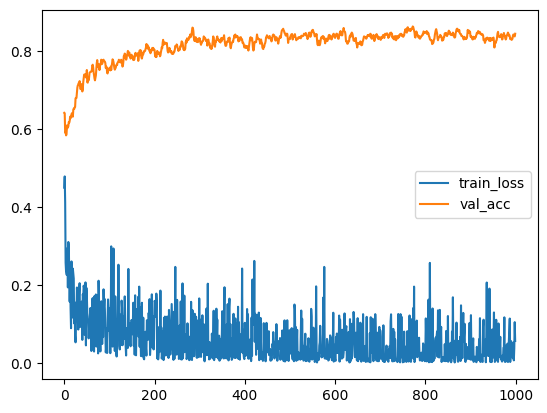

In [34]:
logs_df = pd.DataFrame(logs)
logs_df.plot()

### Evaluate the trained model

In [9]:
!ls /kaggle/input/best-model

best


In [12]:
# Calculating the test-set accuracy.
# We generate embeddings of the train dataset.
# Then we generate embeddings of the test dataset.
# Then we train and score a nearest-neighbour search on the embeddings.
# Note that we use 1-NN for the reported accuracy.

#model = torch.load('/kaggle/working/best')
model = torch.load('/kaggle/input/best-model/best')
train_for_val_dataloader = torch.utils.data.DataLoader(flowers102_train_for_val, batch_size=100, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(flowers102_test, batch_size=100, shuffle=True)

ys = []
y_hats = []
for X, y in tqdm(train_for_val_dataloader):
    #X, y = X.half(), y.half()
    X, y = X.to(device), y.to(device)
    y_hat = model(X)
    ys.append(y.detach().cpu().numpy())
    y_hats.append(y_hat.detach().cpu().numpy())
    #total_val_right += (torch.argmax(y_hat, dim=1) == y).sum().detach().cpu().item()
train_y = np.concatenate(ys).astype(float)
train_y_hat = np.concatenate(y_hats).astype(float)

del X, y
do_gc()

ys = []
y_hats = []
for X, y in tqdm(test_dataloader):
    #X, y = X.half(), y.half()
    X, y = X.to(device), y.to(device)
    y_hat = model(X)
    #y_hat = torch.nn.functional.normalize(y_hat, p=1)
    y_hat = y_hat.to(device)#[:,:102]
    ys.append(y.detach().cpu().numpy())
    y_hats.append(y_hat.detach().cpu().numpy())
    #total_val_right += (torch.argmax(y_hat, dim=1) == y).sum().detach().cpu().item()

test_y = np.concatenate(ys).astype(float)
test_y_hat = np.concatenate(y_hats).astype(float)

del X, y
do_gc()

from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree')
nn.fit(train_y_hat, train_y)
test_acc = nn.score(test_y_hat, test_y)

print("Test accuracy: {}".format(test_acc))

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Test accuracy: 0.8085867620751341


In [60]:
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
nn.fit(train_y_hat, train_y)
test_acc = nn.score(test_y_hat, test_y)

print("Test accuracy: {}".format(test_acc))

Test accuracy: 0.8100504147015775


## Visualisation with UMAP

UMAP is a well-known algorithm for unsupervised dimensionality reduction. It is used here for visualising the learnt embedding space in two dimensions, as a form of model interpretability.

In [13]:
import umap

2024-04-06 05:10:47.413634: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 05:10:47.413775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 05:10:47.543803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
mapper = umap.UMAP().fit(test_y_hat)

AttributeError: module 'umap' has no attribute 'plot'

In [35]:
import umap.plot

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/cudf/utils/_numba.py:110: UserWarning: Using CUDA toolkit version (12, 4) with CUDA driver version (12, 2) requires minor version compatibility, which is not yet supported for CUDA driver versions 12.0 and above. It is likely that many cuDF operations will not work in this state. Please install CUDA toolkit version (12, 2) to continue using cuDF.
  warnings.warn(


<Axes: >

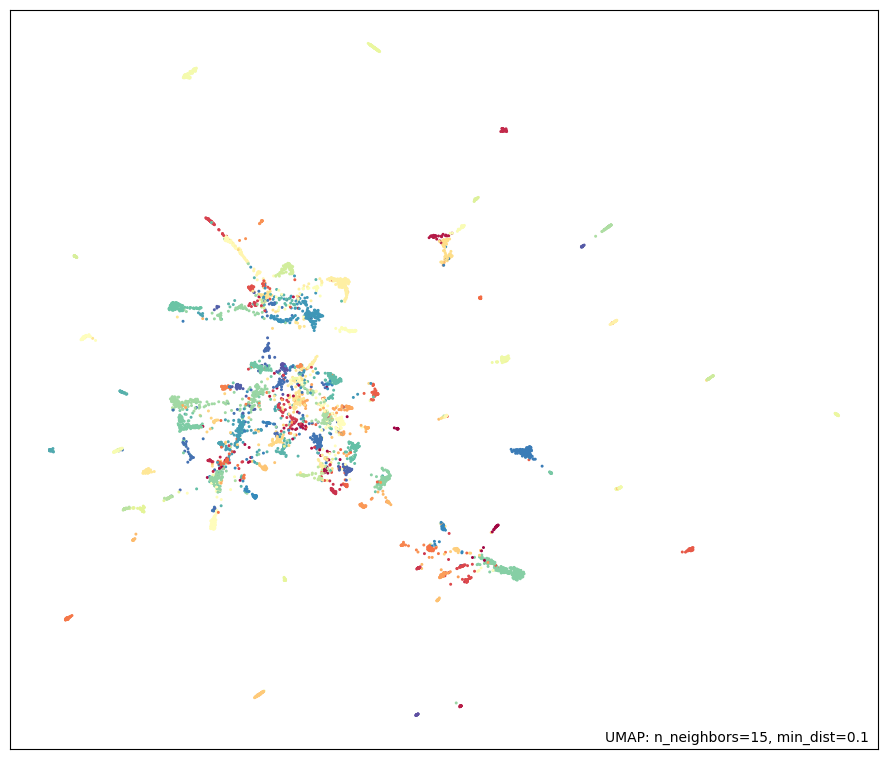

In [54]:
fig, ax = plt.subplots(figsize=(5.6*2, 4.8*2))
umap.plot.points(mapper, labels=test_y, cmap='viridis', show_legend=False, ax=ax)